# Global Modelling
@author Carl Christian Roll-Lund

This workbook ties into the Max-Flow problem and Robustness Simulation, as well as preliminary plots and interactive maps of the data.
Step 0 and Step 1.1-1.2 are needed to run for later sections, other than that the code is somewhat modular, where you should run through from start to finnish within the numbered sections i.e if you want to run 4.3 you should run the previous sections within section 4 first (mainly functions are defined at the start)
- Step 0: Imports & Data Loading: Importing used Libraries and loading Data (CSV's of nodes & edges for Oslo-only and extended version)

- Step 1.1: Defining Capacity:  
    def capacity_from_mode(mode, daily_trips, mode_selection): calculates capacity for edges by mode

- Step 1.2: Uses Networkx to create a Directed Graph  
    def modelMaker(nodes, edges): Uses NetworkX to create a directed graph, adding nodes(stops) and edges(departures) to the graph. Also adding geographcical coordinates as node attributes.
    
- Step 1.3: Calculates Corridor Capacity: Example calculation given to Railway responsible author  
    def find_station_ids(G, station_name): Return unique node ID for all nodes that contain input station_name  
    def compute_corridor_capacity(G, source_name, target_name): computes max_flow for given corridors where origin and destination are based on station names

- Step 2.1: Grouped Plotting: Plotting points with geographical coordinates to achieve a visualization of the network.  
    def modelPlotter(graph, position, name, out): plotting geo-graph using graph and position from modelMaker, name is title of graph, and out is filepath for saving image (Result shown in report Appendix A)

- Step 2.2 Plotting per mode:  
    def modeGroupedPlotter(graph, position, name, out): same as modelPlotter but subgraphed per mode (Result shown in report Appendix A)    

- Step 3 Interactive Map Overlays:  
    def mapMaker(graph, name): takes in graph, and name as resulting filename, to then loop over all nodes/edges and plot/draw lines on an interactive map saved in multiple .HTML files, split per mode and per dataset (Result shown in /Modeling/Carl/interactiveView)    

- Step 4 Max Flow Experiment  
- Step 4.1 Adding Walk/Transfer Edges m=50  
    def haversine_m(lat1, lon1, lat2, lon2): basic trigonometry for returning length in meters between two given coordinates  
    def add_walk_edges_by_proximity(G, max_dist_m, big_capacity, capacity_attr="capacity"): Adding walking/transfer edges to a graph, so that inter-modal travel is allowed.     

- Step 4.2 Building Source & Sink + Max Flow: also includes subgraphing  
    def build_super_source_sink(G, origins, destinations, capacity_attr="capacity"): Adds 2 new nodes, 1 supersink and one supersource that are tied to all destinations and origins respectively, standard when testing flow through a network.  
    def run_max_flow(G, origins, destinations, capacity_attr="capacity"): Takes given parameters, builds sink/source and runs a maximum_flow (NetworkX) algorithm and returns max flow value, a flow_dict showing how the flow was routed, the super-soruce node id, the super-sink node id and the augmented graph  
    def subgraph_modes(G, allowed_modes, origins, destinations): helper function to subgraph by removing any nodes/edges that doesnt meet the mode specification given as input

- Step 4.3 Max flow Scenarios  
- Step 4.3.1 Central Hib -> Outer Zone: Runs the 1st Max-Flow Scenario, as well as a preliminary summary of findings, as this was the first run I did.  
    def central_outer_hubs(g_oslo): Finds all nodes within a 500 meter radius of Oslo S for a given graph    

- Step 4.3.2 Outer Zone -> Central Hub: Runs the 2nd Max-Flow Scenario (same as 4.3.1 but flipped direction)

- Step 4.3.3 Through the Hub; Runs 3rd Max-Flow Scenario (Asker to Lillestrøm and Lillestrøm to Asker)  
    def node_grouper(node_collection, node_names, node_radius_m, in_lat, in_lon): A more modular approach to node grouping to create destination and origin nodes for super sink/source

- Step 4.3.4 Summarized Results as Barchart: Brute forced barchart based on prints from 4.3.1 to 4.3.3  
    def plot_grouped_barchart(scenario_list, colors, title): Modular way to plot barcharts from Max-Flow Results (Findings here shown in Results section for Max-Flow)
    

- Step 4.4 Robustness  
    def node_flow_scores(flow_dict, S, T): calculates node_flow scores for all nodes in a given flow_dictionary (return from run_max_flow()), it returns it as a default dictionary  
    def simulate node_removals(G_base, modes, origins, destinations, critical_nodes, capacity_attr="capacity", single_only, verbose): Takes in a graph, then based on single_only either removes nodes independtly (True) or removes them accumulitavily(False), for each removal it reruns the run_max_flow calculating remaining flow after every step.  
    def direct_attack_robust_sim(g, origins, destinations, title, modes): takes in graph and send in one and one node for removal to simulate_node_removal, and returns the full robust_results (with baseline score and score after each removal)  
    def random_attack_robust_sim(g, origins, destinations, title, modes, k=10, seed=None): pretty much the same as the direct attack, but picks nodes for removal at random (the ones it sends into the simulate_node_removal()), the Seed part was added so that i in theory could get reproducible results, but due to this simulation being quite heavy to run i opted out of running a seeded run as well, but left the code there for possible future runs  
    def append_results_to_csv(filename, mode_label, experiment_label, graph_label, attack_type, run_id, results): This is the function that actually runs the whole robustness sim setup and saves the results to robustness_results.csv (which is the base for all findings presented in the report regarding the Area under the Curve), subsequent plotting and models are based on this one.

- Step 4.5 Plotting Robustness: As the amount of produced data was a lot, I went back and forth between different designs to visualize and find different ways of showing the data  
    def plot_exp_with_both_graphs(exp, title, outfile=None): Filters dataset down to oneexperiment and cumulative node removals, then for each graph variant a plot of the targeted attack and random attack mean curve  
    def plot_robustness_experiments(csv_path): Generates 4 linecharts for each scenario (2 for the last one), Clear lines equals directed attacks, dashed lines equals random attacks, blue equals Oslo Only graph, and orange equals extended graph, this function was used to create the linecharts presented in the report under the results section for Robustness Simulation

- Step 4.6 Unused Experimental Plotting: A collection of line charts with per mode view, a heatmap and one single massive linechart with a very modular view...

- Step 4.7 AUC min-max: quick calculation for AUC min-max as seen in the results robustness section of the report


## Step 0 - Imports & Data Loading

In [ ]:
!pip install -r requirements.txt 
#Run this to install Python requirments

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium
import numpy as np
import math
from typing import Iterable, Tuple, Set, Hashable
from collections import defaultdict
import os
import contextlib
import sys
import dataframe_image as dfi


#Oslo = county/Fylke 03
nodes_oslo = pd.read_csv("../../Extraction/out/nodes_GTFS_OSLO.csv")
edges_oslo = pd.read_csv("../../Extraction/out/edges_GTFS_OSLO_with_mondayTrips.csv")

#Greater Area: Oslo (03), Akershus(32), Buskerud (33), Østfold (31)
nodes_oslo_extended = pd.read_csv("../../Extraction/out/nodes_GTFS_ALL_FYLKER.csv")
edges_oslo_extended = pd.read_csv("../../Extraction/out/edges_GTFS_ALL_FYLKER_with_mondayTrips.csv")

#display(nodes_oslo.head()) 
#display(edges_oslo.head())
#display(nodes_oslo_extended.head()) 
#display(edges_oslo_extended.head())
print(f"Edges shape Oslo: {edges_oslo.shape} | Nodes/Stops shape: {nodes_oslo.shape}")
print("Unique modes in edges:", edges_oslo["mode"].unique())
print("Counts per mode:")
print(edges_oslo["mode"].value_counts())
print(f"\nEdges shape Oslo w/ Selected Neighbours: {edges_oslo_extended.shape} | Nodes/Stops shape: {edges_oslo_extended.shape}")
print("Unique modes in edges:", edges_oslo_extended["mode"].unique())
print("Counts per mode:")
print(edges_oslo_extended["mode"].value_counts())

Edges shape Oslo: (4825, 9) | Nodes/Stops shape: (1941, 7)
Unique modes in edges: ['bus' 'rail' 'coach service' 'unknown' 'metro' 'tram']
Counts per mode:
mode
bus              3896
metro             372
tram              300
rail              194
coach service      49
unknown            14
Name: count, dtype: int64

Edges shape Oslo w/ Selected Neighbours: (42538, 9) | Nodes/Stops shape: (42538, 9)
Unique modes in edges: ['unknown' 'bus' 'coach service' 'rail' 'metro' 'tram']
Counts per mode:
mode
bus              40016
rail              1156
coach service      605
metro              404
tram               300
unknown             57
Name: count, dtype: int64


## Step 1.1: Defining Capacity

In [3]:
#Function takes in mode, daily_trips and a mode_selection array(legal modes)
#Returns capacity for mode_edge as daily_trips * mode_multiplier
def capacity_from_mode(mode: str, daily_trips: float, mode_selection) -> float:
    """
    Convert daily number of trips + mode into a capacity value for max-flow.
    You can interpret it as 'seats per day' or just a relative weight.
    """

    # If mode isn't one of the allowed types, no capacity.
    if mode not in mode_selection:
        return 0.0

    if daily_trips is None or (isinstance(daily_trips, float) and math.isnan(daily_trips)):
        return 0.0

    if daily_trips <= 0:
        return 0.0

    # Rough multipliers
    mode_multipliers = {
        "unknown": 40,         # generic low capacity for unknown nodes (retroperspective, should probably have removed these instead)
        "bus": 50,             # typical bus has between 46-57 seats
        "coach service": 60,   # long-distance / airport coaches oftne larger than normal bus
        "rail": 560,           # trains, 1=carriage ca. 56 seter * 10 for normal kjøring (type 75 motorvogn)
        "metro": 800,          # MX3000 trains, divided to sets of 3-car units, often run two coupled units aka 6 cars total. Sporveien mentions capacity of 800 https://www.sporveien.no/vare-tjenester/t-banen/t-banetogene-vare
        "tram": 180,           # trams/trikk, SL95 (newest blue model in oslo) har 212 capacity while older SL79 got 160 so ill do 180
    }

    base = mode_multipliers.get(mode, 40)  # default to "unknown"-ish

    return float(daily_trips) * base

## Step 1.2 Creating the model (Edge & Node Definitions)

In [4]:
def modelMaker(nodes: pd.DataFrame, edges: pd.DataFrame):
    G = nx.DiGraph()

    # Which modes we actually model as having capacity
    modeSelection = ["unknown", "bus", "coach service", "rail", "metro", "tram"]

    # 1) Add nodes
    for _, row in nodes.iterrows():
        node_id = row["id"]
        G.add_node(
            node_id,
            stopPlaceId=row.get("stopPlaceId"),
            name=row.get("name"),
            lat=row.get("lat"),
            lon=row.get("lon"),
            modes=row.get("modes"),
            stopType=row.get("stopType"),
        )

    # 2) Add edges
    for _, row in edges.iterrows():
        u = row["from"]
        v = row["to"]
        mode = row.get("mode")

        daily_trips = row.get("tripsOn2025_11_17", 0)
        try:
            daily_trips = float(daily_trips) if daily_trips is not None else 0.0
        except (TypeError, ValueError):
            daily_trips = 0.0

        travel_time = row.get("travelTimeSec", None)
        if travel_time is not None:
            try:
                travel_time = float(travel_time)
            except (TypeError, ValueError):
                travel_time = None

        capacity = capacity_from_mode(mode, daily_trips, modeSelection)

        G.add_edge(
            u,
            v,
            lineId=row.get("lineId"),
            lineCode=row.get("lineCode"),
            mode=mode,
            authority=row.get("authority"),
            travelTimeSec=travel_time,
            dailyTrips=daily_trips,
            capacity=capacity,
        )

    # 3) Final graph stats
    print("Graph nodes:", G.number_of_nodes())
    print("Graph edges:", G.number_of_edges())

    # 4) Positions for plotting / layout
    pos = {
        n: (data["lon"], data["lat"])
        for n, data in G.nodes(data=True)
        if data.get("lon") is not None and data.get("lat") is not None
    }
    print(f"Positions built for {len(pos)} nodes.")

    return G, pos

In [5]:
g_oslo, pos_oslo = modelMaker(nodes_oslo, edges_oslo)
g_oslo_extended, pos_oslo_extended = modelMaker(nodes_oslo_extended, edges_oslo_extended)

Graph nodes: 1941
Graph edges: 2430
Positions built for 1941 nodes.
Graph nodes: 15838
Graph edges: 21385
Positions built for 15838 nodes.


## Step 1.3 Corridor Capacity (For Use in Headway Railway Experiment)

In [5]:
def find_station_ids(G, station_name):
    """
    Returns all node IDs in the graph whose 'name' contains the given station_name.
    Case-insensitive.
    """
    station_name = station_name.lower()
    nodes = []
    for n, data in G.nodes(data=True):
        name = str(data.get("name", "")).lower()
        if station_name in name:
            nodes.append(n)
    return nodes

def compute_corridor_capacity(G, source_name, target_name):
    """
    Computes max-flow capacity between two stations using all platform IDs.
    """
    # find all platform-level node IDs
    sources = find_station_ids(G, source_name)
    targets = find_station_ids(G, target_name)

    if not sources:
        raise ValueError(f"No nodes found for source station '{source_name}'")
    if not targets:
        raise ValueError(f"No nodes found for target station '{target_name}'")

    super_source = "SUPER_SOURCE"
    super_sink = "SUPER_SINK"

    G_aug = G.copy()
    for s in sources:
        G_aug.add_edge(super_source, s, capacity=float("inf"))

    for t in targets:
        G_aug.add_edge(t, super_sink, capacity=float("inf"))

    flow_value, flow_dict = nx.maximum_flow(
        G_aug,
        super_source,
        super_sink,
        capacity="capacity"
    )

    return flow_value

asker_to_oslos_flow = compute_corridor_capacity(
    g_oslo_extended,    
    "Asker stasjon",
    "Oslo S"
)

print("Max-flow capacity Asker → Oslo S:", asker_to_oslos_flow)


Max-flow capacity Asker → Oslo S: 557740.0


In [6]:
#Finding Highest Capacity here, used to define Max-Capacity when adding walking/transfer edges later
#This is done so that we put the max-capacity of walking edges around the max flow of edges, so we dont bloat the network with ridicilous high capacity on walking edges.
edges_sorted = sorted(
    g_oslo.edges(data=True),
    key=lambda x: x[2].get("capacity", 0),
    reverse=True
)

for u, v, data in edges_sorted[:10]:
    print(u, "→", v, data["capacity"], data.get("mode"))


NSR:Quay:551 → NSR:Quay:870 412160.0 rail
NSR:Quay:515 → NSR:Quay:276 412160.0 rail
NSR:Quay:276 → NSR:Quay:600 412160.0 rail
NSR:Quay:600 → NSR:Quay:505 412160.0 rail
NSR:Quay:505 → NSR:Quay:641 412160.0 rail
NSR:Quay:641 → NSR:Quay:869 412160.0 rail
NSR:Quay:869 → NSR:Quay:561 412160.0 rail
NSR:Quay:869 → NSR:Quay:553 412160.0 rail
NSR:Quay:869 → NSR:Quay:554 412160.0 rail
NSR:Quay:869 → NSR:Quay:550 412160.0 rail


## Step 2.1: Grouped Plotting
Here we are plotting the entire graph, with all nodes and edges combined

In [7]:
def modelPlotter(graph, position, name, out):
    mode_colors = {
        "bus":        "#1f77b4",   # deep blue
        "tram":       "#d62728",   # strong red
        "metro":      "#9467bd",   # purple 
        "rail":       "#2ca02c",   # green 
        "coach":      "#ff7f0e",   # orange
        "water":      "#17becf",   # teal
        "unknown":    "#7f7f7f",   # neutral gray
    }
    
    edge_colors = [
        mode_colors.get(data["mode"], "gray") 
        for _, _, data in graph.edges(data=True)
    ]
    
    plt.figure(figsize=(12, 14))
    nx.draw(
        graph,
        position,
        node_size=3,
        node_color="black",
        edge_color=edge_colors,
        width=0.2,
        alpha=0.4,
        with_labels=False
    )
    
    plt.title(name, fontsize=16)
    plt.axis("off")
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()

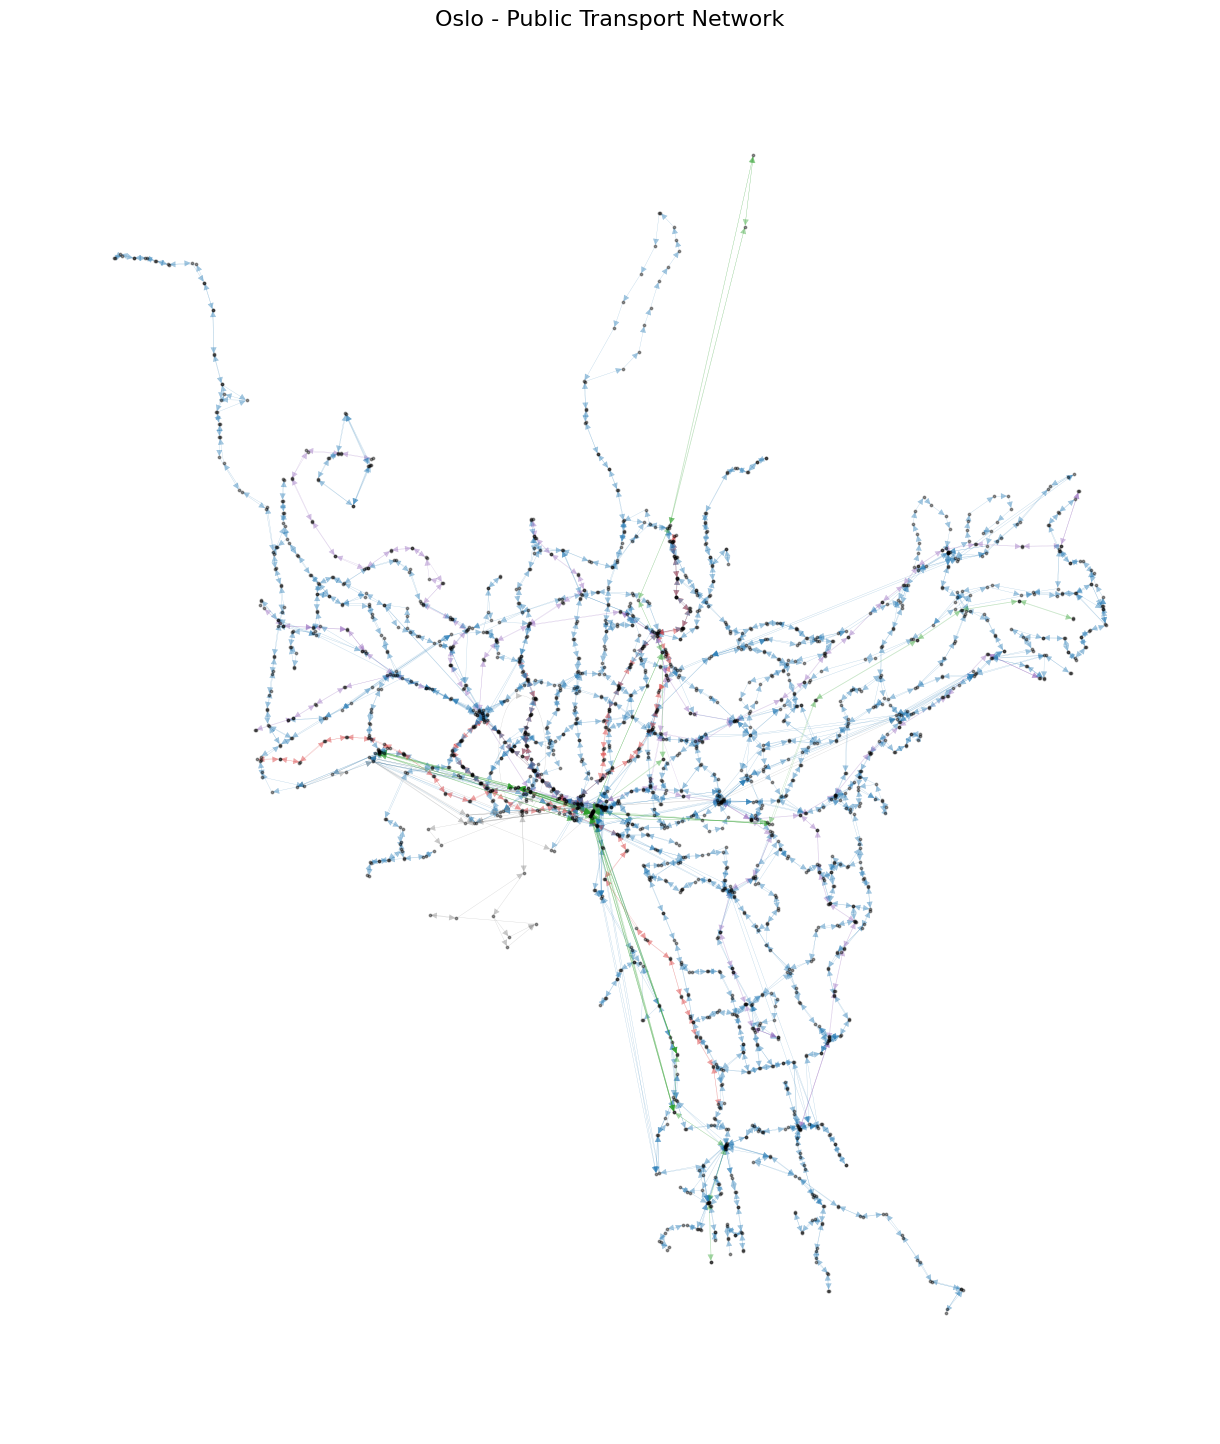

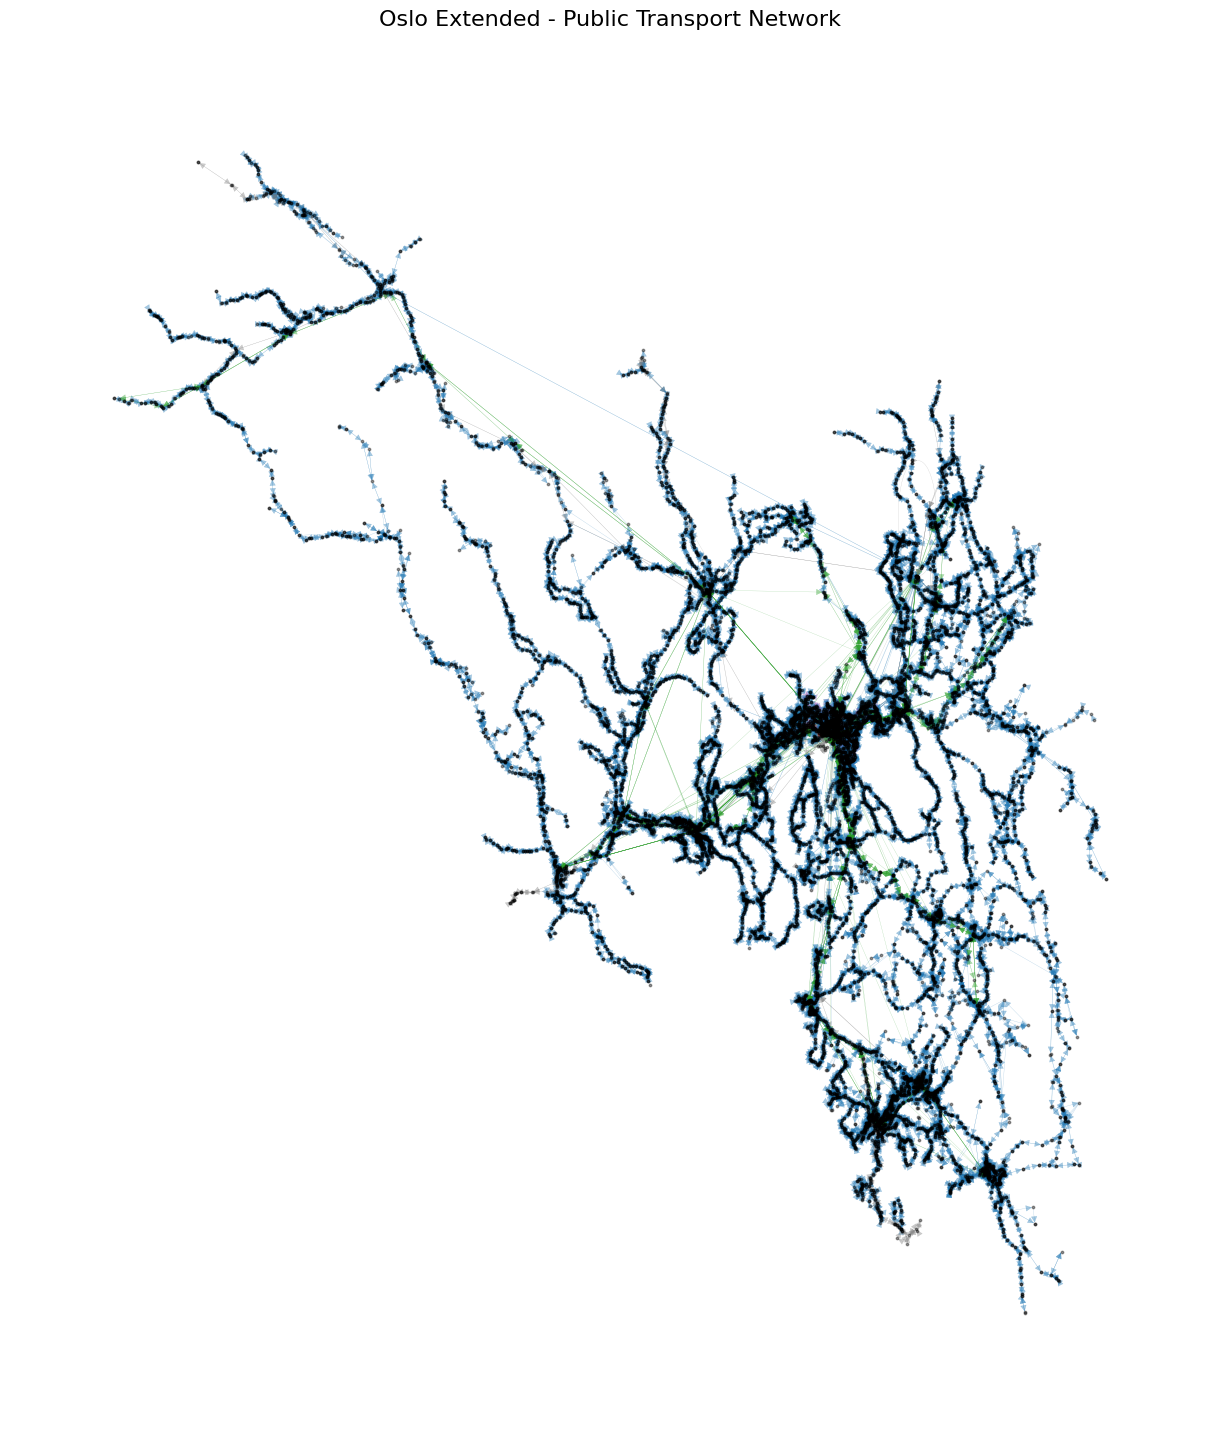

In [11]:
modelPlotter(g_oslo, pos_oslo,"Oslo - Public Transport Network", "images/OsloRawNetworkColorCoded.png")
modelPlotter(g_oslo_extended, pos_oslo_extended,"Oslo Extended - Public Transport Network", "images/OsloExtendedRawNetworkColorCoded.png")

## Step 2.2 Plotting per mode

In [12]:
def modeGroupedPlotter(graph, position, name, out):
    mode_colors = {
        "bus":        "#1f77b4",   # deep blue
        "tram":       "#d62728",   # strong red
        "metro":      "#9467bd",   # purple 
        "rail":       "#2ca02c",   # green 
        "coach":      "#ff7f0e",   # orange
        "water":      "#17becf",   # teal
        "unknown":    "#7f7f7f",   # neutral gray
    }
    modes = ['bus', 'rail', 'coach service', 'metro', 'tram']
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(name, fontsize=16)

    for ax, mode in zip(axs.flat, modes):
        ax.set_title(mode.capitalize(), fontsize=10)
    
        edges_of_mode = [
            (u, v) for u, v, data in graph.edges(data=True)
            if data.get("mode") == mode
        ]
    
        nodes_of_mode = set()
        for u, v in edges_of_mode:
            nodes_of_mode.add(u)
            nodes_of_mode.add(v)
    
        edge_colors = [mode_colors.get(mode, "gray")] * len(edges_of_mode)
    
        nx.draw(
            graph,
            position,
            ax=ax,
            with_labels=False,
            nodelist=list(nodes_of_mode),
            edgelist=edges_of_mode,
            node_size=2,        
            node_color="black",
            edge_color=edge_colors,
            width=0.4,          
            alpha=0.9
        )
    
        ax.axis("off")
    axs.flat[-1].axis("off")

    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()


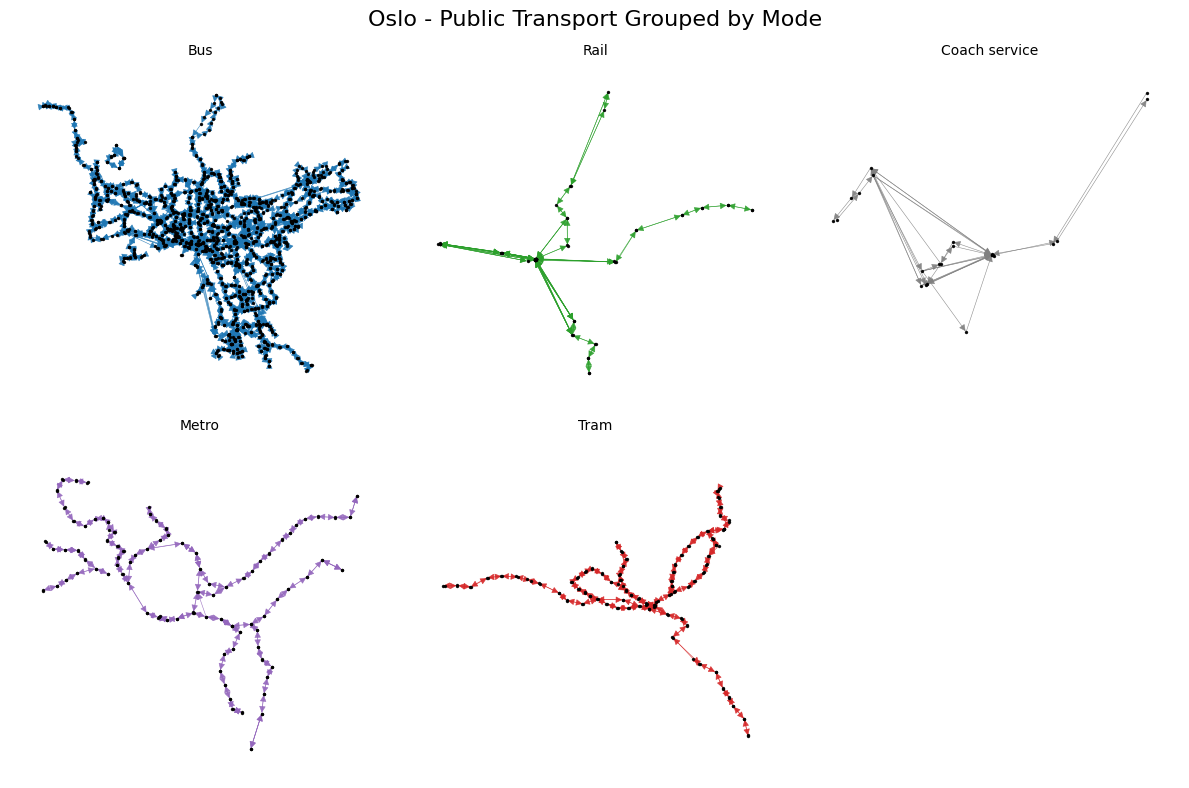

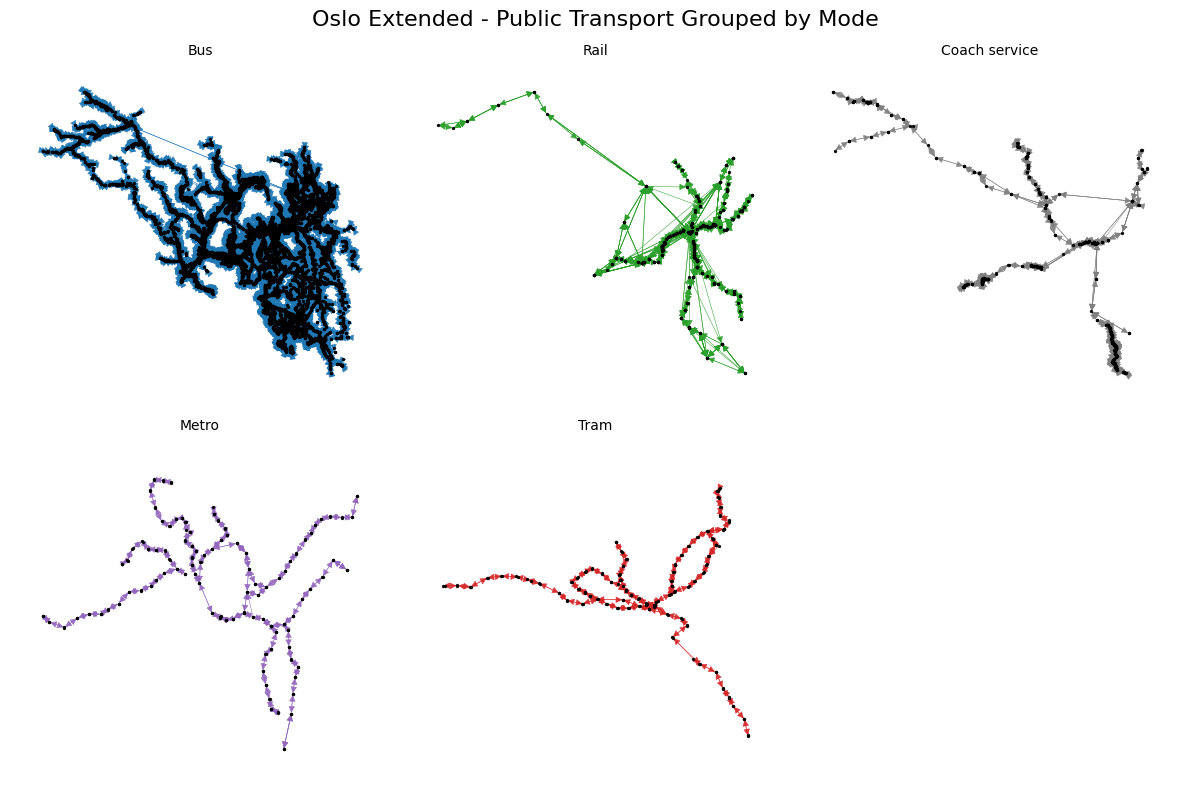

In [13]:
modeGroupedPlotter(g_oslo, pos_oslo,"Oslo - Public Transport Grouped by Mode","images/OsloNetworkGroupedByMode.png")
modeGroupedPlotter(g_oslo_extended, pos_oslo_extended,"Oslo Extended - Public Transport Grouped by Mode","images/OsloExtendedNetworkGroupedByMode.png")

## Step 3 Interactive Map Overlays
Here we are using the Library Folium to overlay our Nodes/Edges latitude and longitude values over an actual map, creating a series for HTML files, which upon inspection can be zoomed in on.

In [8]:
def mapMaker(graph, name):
    mode_colors = {
        "bus":        "#1f77b4",   # deep blue
        "tram":       "#d62728",   # strong red
        "metro":      "#9467bd",   # purple 
        "rail":       "#2ca02c",   # green 
        "coach":      "#ff7f0e",   # orange
        "water":      "#17becf",   # teal
        "unknown":    "#7f7f7f",   # neutral gray
    }
    modes = ['bus', 'rail', 'coach service', 'metro', 'tram']
    for mode in modes:
        m = folium.Map(
            location=[59.9139, 10.7522],
            zoom_start=12,
            tiles="cartodbpositron"
        )
    
        # edges
        for u, v, data in graph.edges(data=True):
            if data.get("mode") != mode:
                continue
    
            lat1, lon1 = graph.nodes[u]["lat"], graph.nodes[u]["lon"]
            lat2, lon2 = graph.nodes[v]["lat"], graph.nodes[v]["lon"]
    
            folium.PolyLine(
                locations=[(lat1, lon1), (lat2, lon2)],
                color=mode_colors.get(mode, "gray"),
                weight=2,
                opacity=0.8
            ).add_to(m)
    
        # nodes
        for n in graph.nodes:
            # only nodes belonging to this mode
            if mode not in graph.nodes[n]["modes"]:
                continue
    
            folium.CircleMarker(
                location=(graph.nodes[n]["lat"], graph.nodes[n]["lon"]),
                radius=2,
                color="black",
                fill=True,
                fill_opacity=1
            ).add_to(m)
    
        # save output
        filename = f"InteractiveView/{name}_{mode.replace(' ', '_')}.html"
        m.save(filename)
        
    
    # 2. MASTER HTML WITH ALL MODES
    m_all = folium.Map(
        location=[59.9139, 10.7522],
        zoom_start=12,
        tiles="cartodbpositron"
    )
    
    for u, v, data in graph.edges(data=True):
        lat1, lon1 = graph.nodes[u]["lat"], graph.nodes[u]["lon"]
        lat2, lon2 = graph.nodes[v]["lat"], graph.nodes[v]["lon"]
        mode = data.get("mode")
    
        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color=mode_colors.get(mode, "gray"),
            weight=1.5,
            opacity=0.7,
        ).add_to(m_all)
    
    for n in graph.nodes:
        folium.CircleMarker(
            location=(graph.nodes[n]["lat"], graph.nodes[n]["lon"]),
            radius=1.5,
            color="black",
            fill=True,
            fill_opacity=1
        ).add_to(m_all)
    
    m_all.save(name+"_all_modes.html")


In [9]:
mapMaker(g_oslo, "Oslo")
mapMaker(g_oslo_extended, "Oslo_Extended")

## Step 4 - Max Flow Experiment

### 4.1 Adding Walk/Transfer Edges m=50 (inter-station walking only)

In [10]:
# Haversine: "luftlinje" or air line/straight line distance between two coordinates (trigonometry)
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of earth in meter aprox.
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = phi2 - phi1
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def add_walk_edges_by_proximity(
    G: nx.DiGraph,
    max_dist_m: float = 50.0,
    big_capacity: float = 412160*3,
    capacity_attr: str = "capacity",
):
    """
    Adding high capacity "walk"/transfer edges between nodes that appear closeby each other (<50m).
    The walk edges are bidirectional and are set to its own mode="walk", authority="transfer" and travelTimeSec
    becomes (haversine-distance / 1.3 m/s walking spepd). The large capacity is to show that there isnt really a known
    limit to how many people can decide to walk between stations (as this would be station to station specific).
    """

    # 1) Gathering all nodes that have valid coordinates, altough I ended up cleaning this out at an earlier stage later 
    coord_nodes = []
    for n, data in G.nodes(data=True):
        lat = data.get("lat")
        lon = data.get("lon")
        if lat is None or lon is None:
            continue
        coord_nodes.append((n, float(lat), float(lon)))

    print(f"Nodes with coordinates: {len(coord_nodes)}")

    # 2) Grouping into possible candidates so we dont have to check distance between all nodes (took too long, trust me i tried)
    cell_size_deg = 0.002 
    buckets = {}
    for n, lat, lon in coord_nodes:
        key = (round(lat / cell_size_deg), round(lon / cell_size_deg))
        buckets.setdefault(key, []).append((n, lat, lon))

    added = 0

    # 3) For each bucket check against yourself + against all neighbour buckets
    neighbors_offsets = [
        (0, 0),
        (1, 0), (-1, 0),
        (0, 1), (0, -1),
        (1, 1), (1, -1), (-1, 1), (-1, -1),
    ]
    
    for key, nodes_here in buckets.items():
        candidate_nodes = []
        for dx, dy in neighbors_offsets:
            nb_key = (key[0] + dx, key[1] + dy)
            if nb_key in buckets:
                candidate_nodes.extend(buckets[nb_key])

        #deduping candidates
        candidate_nodes = list({n for n in candidate_nodes})

        # checking candidates
        for i in range(len(nodes_here)):
            n1, lat1, lon1 = nodes_here[i]
            for n2, lat2, lon2 in candidate_nodes:
                if n1 >= n2:
                    continue
                d = haversine_m(lat1, lon1, lat2, lon2)
                if d <= max_dist_m: #This is where we make the finall check to the actual 50m rule
                    for u, v in ((n1, n2), (n2, n1)):
                        if not G.has_edge(u, v):
                            G.add_edge(
                                u,
                                v,
                                mode="walk",
                                authority="transfer",
                                travelTimeSec=d / 1.3,  
                                **{capacity_attr: big_capacity},
                            )
                            added += 1
    
    print(f"Added ~{added} walk/transfer edges (<= {max_dist_m}m).")
    return G


In [11]:
g_oslo_extended = add_walk_edges_by_proximity(g_oslo_extended, max_dist_m=50.0)
g_oslo = add_walk_edges_by_proximity(g_oslo, max_dist_m=50.0)

Nodes with coordinates: 15838
Added ~12565 walk/transfer edges (<= 50.0m).
Nodes with coordinates: 1941
Added ~2332 walk/transfer edges (<= 50.0m).


### 4.2 Building Source & Sink + Max Flow

In [10]:
def build_super_source_sink(
    G: nx.DiGraph,
    origins,
    destinations,
    capacity_attr="capacity",
):
    H = G.copy()
    S = "__SUPER_SOURCE__"
    T = "__SUPER_SINK__"

    H.add_node(S)
    H.add_node(T)

    # ensure uniqueness
    origins = set(origins)
    destinations = set(destinations)

    # S -> origins
    for o in origins:
        if o not in H:
            continue
        out_cap = 0.0
        for _, _, data in H.out_edges(o, data=True):
            c = data.get(capacity_attr, 0.0) or 0.0
            out_cap += float(c)
        if out_cap > 0:
            H.add_edge(S, o, **{capacity_attr: out_cap})

    # destinations -> T
    for d in destinations:
        if d not in H:
            continue
        in_cap = 0.0
        for _, _, data in H.in_edges(d, data=True):
            c = data.get(capacity_attr, 0.0) or 0.0
            in_cap += float(c)
        if in_cap > 0:
            H.add_edge(d, T, **{capacity_attr: in_cap})

    print(f"Super-source connected to {len(origins)} origins.")
    print(f"Super-sink connected from {len(destinations)} destinations.")

    return H, S, T


def run_max_flow(
    G: nx.DiGraph,
    origins,
    destinations,
    capacity_attr="capacity",
):
    H, S, T = build_super_source_sink(G, origins, destinations, capacity_attr)

    flow_value, flow_dict = nx.maximum_flow(
        H, #Helper graph (the augmented version of the original graph)
        S, #Super-source or the "global start"
        T, #Super-sink or "global end"
        capacity=capacity_attr,
    )

    print(f"Max flow from origins -> destinations: {flow_value:.2f}")
    return flow_value, flow_dict, S, T, H


In [11]:
def subgraph_modes(G, allowed_modes, origins, destinations):
    H = G.copy()

    # 1) Remove edges that are not in the allowed modes (but keep 'walk')
    for u, v, data in list(H.edges(data=True)):
        m = data.get("mode")
        if m not in allowed_modes and m != "walk":
            H.remove_edge(u, v)

    # 2) Remove isolated nodes (no in/out edges)
    H.remove_nodes_from(list(nx.isolates(H)))

    # 3) Filtering nodes as well, keeping the multimodal ones though
    nodes_to_remove = []
    for n, data in H.nodes(data=True):
        node_mode = data.get("mode")
        if node_mode is not None:
            if node_mode not in allowed_modes and node_mode != "multimodal":
                nodes_to_remove.append(n)

    if nodes_to_remove:
        H.remove_nodes_from(nodes_to_remove)
        # after removing nodes, some others might become isolates
        H.remove_nodes_from(list(nx.isolates(H)))

    # 4) Filter origins / destinations to nodes that still exist & can send/receive flow
    new_origins = [
        o for o in origins
        if o in H and H.out_degree(o) > 0
    ]
    new_destinations = [
        d for d in destinations
        if d in H and H.in_degree(d) > 0
    ]

    return H, new_origins, new_destinations


In [12]:
#Just a simple test for flow_values choosing arbitrary origins(source)/destinations(sink)

flow_value, flow_dict, H, S, T = run_max_flow(
    g_oslo,
    origins=["NSR:Quay:11969"],
    destinations=["NSR:Quay:872", "NSR:Quay:1173"],
    capacity_attr="capacity",
)
print("Max flow with transfers OSLO:", flow_value)

flow_value, flow_dict, H, S, T = run_max_flow(
    g_oslo_extended,
    origins=["NSR:Quay:11969"],
    destinations=["NSR:Quay:872", "NSR:Quay:1173"],
    capacity_attr="capacity",
)
print("Max flow with transfers OSLO Extended:", flow_value)


Super-source connected to 1 origins.
Super-sink connected from 2 destinations.
Max flow from origins -> destinations: 18150.00
Max flow with transfers OSLO: 18150.0
Super-source connected to 1 origins.
Super-sink connected from 2 destinations.
Max flow from origins -> destinations: 18150.00
Max flow with transfers OSLO Extended: 18150.0


## 4.3 Max Flow Scenarios

### 4.3.1 Central Hub -> Outer Zone
Creating a hub collection of nodes, and then defining any nodes outside as sink will show how effective the network is at sending passengers out from the hub

In [13]:
def central_outer_hubs(g_oslo):
    oslo_s_lat = 59.910261 #Just took Oslo S rail cord
    oslo_s_lon = 10.754866
    hub_radius_m = 500
    
    hub_names = ["Oslo S", "Jernbanetorget"]
    
    hub_nodes = []
    
    for n, data in g_oslo.nodes(data=True):
        name = data.get("name")
        lat = data.get("lat")
        lon = data.get("lon")
    
        # 1. Name-based hub members
        if name in hub_names:
            hub_nodes.append(n)
            continue
    
        # 2. Within 500 m radius of Oslo S
        if lat is not None and lon is not None:
            d = haversine_m(lat, lon, oslo_s_lat, oslo_s_lon)
            if d <= hub_radius_m:
                hub_nodes.append(n)
    
    hub_nodes = set(hub_nodes)
    
    # Outer zone = all remaining Oslo nodes (since this dataset *only* has Oslo)
    dest_nodes = [n for n in g_oslo.nodes if n not in hub_nodes]

    print("amount of hub nodes: ",len(hub_nodes))
    print("amount of dest nodes: ",len(dest_nodes))
    return hub_nodes, dest_nodes

In [35]:
origins, destinations = central_outer_hubs(g_oslo)

modes_to_test = {
    "all": ["bus", "rail", "metro", "tram"], 
    "bus": ["bus"],
    "rail": ["rail"],
    "metro": ["metro"],
    "tram": ["tram"]
}

results = {}

for label, modes in modes_to_test.items():
    print(f"\n=== Running {label.upper()} ===")

    Gm, origins, destinations = subgraph_modes(g_oslo, modes, origins, destinations)

    flow_val, _, _, _, _ = run_max_flow(
        Gm,
        origins=origins,
        destinations=destinations,
        capacity_attr="capacity",
    )

    results[label] = flow_val
    print(f"{label} flow:", flow_val)



amount of hub nodes:  74
amount of dest nodes:  1867

=== Running ALL ===
Super-source connected to 74 origins.
Super-sink connected from 1833 destinations.
Max flow from origins -> destinations: 3798350.00
all flow: 3798350.0

=== Running BUS ===
Super-source connected to 73 origins.
Super-sink connected from 1820 destinations.
Max flow from origins -> destinations: 140650.00
bus flow: 140650.0

=== Running RAIL ===
Super-source connected to 71 origins.
Super-sink connected from 1293 destinations.
Max flow from origins -> destinations: 2152640.00
rail flow: 2152640.0

=== Running METRO ===
Super-source connected to 71 origins.
Super-sink connected from 1293 destinations.
Max flow from origins -> destinations: 341600.00
metro flow: 341600.0

=== Running TRAM ===
Super-source connected to 71 origins.
Super-sink connected from 1293 destinations.
Max flow from origins -> destinations: 182340.00
tram flow: 182340.0


In [36]:
origins, destinations = central_outer_hubs(g_oslo)

modes_to_test = {
    "all": ["bus", "rail", "metro", "tram"], 
    "bus": ["bus"],
    "rail": ["rail"],
    "metro": ["metro"],
    "tram": ["tram"]
}

results_extended = {}

for label, modes in modes_to_test.items():
    print(f"\n=== Running EXTENDED {label.upper()} ===")

    Gm, origins, destinations = subgraph_modes(g_oslo_extended, modes, origins, destinations)
    
    flow_val, _, _, _, _ = run_max_flow(
        Gm,
        origins=origins,       # same hub
        destinations=destinations,       # same sinks
        capacity_attr="capacity",
    )

    results_extended[label] = flow_val
    print(f"extended {label} flow:", flow_val)

print("\n=== Ratio extended/all (only meaningful if you compare the same modes) ===")

for mode in results_extended:
    if mode in results:  # from your Oslo-only run
        base = results[mode]
        ext  = results_extended[mode]
        if base > 0:
            print(mode, "→", ext/base)
        else:
            print(mode, "→", "no base flow (division skipped)")



amount of hub nodes:  74
amount of dest nodes:  1867

=== Running EXTENDED ALL ===
Super-source connected to 74 origins.
Super-sink connected from 1837 destinations.
Max flow from origins -> destinations: 4517960.00
extended all flow: 4517960.0

=== Running EXTENDED BUS ===
Super-source connected to 73 origins.
Super-sink connected from 1823 destinations.
Max flow from origins -> destinations: 142800.00
extended bus flow: 142800.0

=== Running EXTENDED RAIL ===
Super-source connected to 71 origins.
Super-sink connected from 1294 destinations.
Max flow from origins -> destinations: 2774800.00
extended rail flow: 2774800.0

=== Running EXTENDED METRO ===
Super-source connected to 71 origins.
Super-sink connected from 1294 destinations.
Max flow from origins -> destinations: 341600.00
extended metro flow: 341600.0

=== Running EXTENDED TRAM ===
Super-source connected to 71 origins.
Super-sink connected from 1294 destinations.
Max flow from origins -> destinations: 182340.00
extended tram 

#### Summary of Findings: Max Flow of 4.3.1
In this experiment I treat the **central hub** as all platforms within ~500 meters of Oslo S / Jernbanetorget (74 nodes total), and the **outer zone** as all remaining platforms inside Oslo county (1867 nodes). 
I then run a max-flow from all hub nodes to all outer nodes, on both datasets.
The first dataset being Oslo County only, meaning its restricted to only using edges within Oslo County
Interestingly, I first didnt foresee that there would be any difference when running the same source/sink definitions on the extended dataset, but what ended up happening was that it found optimal routes by travelling to outer nodes (outside of oslo county) and then back in to sink nodes, also solidifying my own understanding of the algorithm as a mathematical optimilization algorithm showcasing not a realistic number but rather a **capacity estimate** in this case of how many passengers one could theoreticaly transport out from the defined hub.

- **Oslo-only graph**
  - Origins (hub nodes): 74  
  - Destinations (outer Oslo nodes): 1867  
  - Max flow (hub → outer): **3,802,790** amount of passengers moved outside hub in 1 day

- **Extended graph (Oslo + neighbouring counties)**
  - Origins: 74  
  - Destinations: 1867 (still only Oslo sinks)  
  - Max flow (hub → outer): **4,524,980** amount of passengers moved outside hub in 1 day

- **Relative change**
  - Ratio extended / Oslo-only: **≈ 1.19**  
  - So including the regional network gives about a **19% increase** in theoretical hub → outer capacity.

### Interpretation of Findings

- The source/sink sets are identical in both runs (same hub nodes, same Oslo-only sinks).
- The only difference is the underlying graph:
  - `g_oslo` only has nodes/edges inside Oslo.
  - `g_oslo_extended` also has routes that leave Oslo and come back in.
- The 19% jump basically means:
  - The model is actually using **detours via neighbouring counties** as extra parallel paths.
  - When I cut the graph to “Oslo-only”, those cross-boundary links disappear, and the hub loses some of its ability to push flow out into the rest of the city.

So the takeaway is that a non-trivial chunk of the **structural** capacity out of the Oslo S / Jernbanetorget hub depends on lines that temporarily leave Oslo county and then re-enter it before fanning out to outer stops.


### 4.3.2 Outer zone -> Central Hub
Opposite of 4.3.1 as we here want to measure effectiveness of moving outsiders into Oslo Hub

In [37]:
print("\n\n### FLIPPED: OUTER → HUB (Oslo only) ###")
destinations, origins = central_outer_hubs(g_oslo) #flipping the vars

modes_to_test = {
    "all": ["bus", "rail", "metro", "tram"], 
    "bus": ["bus"],
    "rail": ["rail"],
    "metro": ["metro"],
    "tram": ["tram"]
}

results = {}

for label, modes in modes_to_test.items():
    print(f"\n=== Running {label.upper()} ===")

    Gm, origins, destinations = subgraph_modes(g_oslo, modes, origins, destinations)

    flow_val, _, _, _, _ = run_max_flow(
        Gm,
        origins=origins,
        destinations=destinations,
        capacity_attr="capacity",
    )

    results[label] = flow_val
    print(f"{label} flow:", flow_val)





### FLIPPED: OUTER → HUB (Oslo only) ###
amount of hub nodes:  74
amount of dest nodes:  1867

=== Running ALL ===
Super-source connected to 1835 origins.
Super-sink connected from 74 destinations.
Max flow from origins -> destinations: 4696680.00
all flow: 4696680.0

=== Running BUS ===
Super-source connected to 1822 origins.
Super-sink connected from 73 destinations.
Max flow from origins -> destinations: 119900.00
bus flow: 119900.0

=== Running RAIL ===
Super-source connected to 1293 origins.
Super-sink connected from 71 destinations.
Max flow from origins -> destinations: 2935520.00
rail flow: 2935520.0

=== Running METRO ===
Super-source connected to 1293 origins.
Super-sink connected from 71 destinations.
Max flow from origins -> destinations: 610400.00
metro flow: 610400.0

=== Running TRAM ===
Super-source connected to 1293 origins.
Super-sink connected from 71 destinations.
Max flow from origins -> destinations: 184140.00
tram flow: 184140.0


In [38]:
print("\n\n### FLIPPED: OUTER → HUB (Extended) ###")
destinations, origins = central_outer_hubs(g_oslo) # flipping the vars

modes_to_test = {
    "all": ["bus", "rail", "metro", "tram"], 
    "bus": ["bus"],
    "rail": ["rail"],
    "metro": ["metro"],
    "tram": ["tram"]
}

results_extended = {}

for label, modes in modes_to_test.items():
    print(f"\n=== Running EXTENDED {label.upper()} ===")

    Gm, origins, destinations = subgraph_modes(g_oslo_extended, modes, origins, destinations)
    
    flow_val, _, _, _, _ = run_max_flow(
        Gm,
        origins=origins,       # same hub
        destinations=destinations,       # same sinks
        capacity_attr="capacity",
    )

    results_extended[label] = flow_val
    print(f"extended {label} flow:", flow_val)

print("\n=== Ratio extended/all (only meaningful if you compare the same modes) ===")

for mode in results_extended:
    if mode in results:  # from your Oslo-only run
        base = results[mode]
        ext  = results_extended[mode]
        if base > 0:
            print(mode, "→", ext/base)
        else:
            print(mode, "→", "no base flow (division skipped)")






### FLIPPED: OUTER → HUB (Extended) ###
amount of hub nodes:  74
amount of dest nodes:  1867

=== Running EXTENDED ALL ===
Super-source connected to 1839 origins.
Super-sink connected from 74 destinations.
Max flow from origins -> destinations: 5334390.00
extended all flow: 5334390.0

=== Running EXTENDED BUS ===
Super-source connected to 1825 origins.
Super-sink connected from 73 destinations.
Max flow from origins -> destinations: 122050.00
extended bus flow: 122050.0

=== Running EXTENDED RAIL ===
Super-source connected to 1294 origins.
Super-sink connected from 71 destinations.
Max flow from origins -> destinations: 3585680.00
extended rail flow: 3585680.0

=== Running EXTENDED METRO ===
Super-source connected to 1294 origins.
Super-sink connected from 71 destinations.
Max flow from origins -> destinations: 610400.00
extended metro flow: 610400.0

=== Running EXTENDED TRAM ===
Super-source connected to 1294 origins.
Super-sink connected from 71 destinations.
Max flow from origins

In [39]:
#quick sanity check using a personaly known route
u = "NSR:Quay:418"
v = "NSR:Quay:635"
print("418 -> 635:", g_oslo_extended[u][v]["capacity"])
print("635 -> 418:", g_oslo_extended[v][u]["capacity"])


418 -> 635: 43120.0
635 -> 418: 43120.0


In [40]:
#Counting up if this is truly a directional symmetrical network or not
same = 0
diff = 0
for u, v, data in g_oslo.edges(data=True):
    if g_oslo.has_edge(v, u):
        c1 = data.get("capacity", 0.0) or 0.0
        c2 = g_oslo[v][u].get("capacity", 0.0) or 0.0
        if abs(c1 - c2) < 1e-9:
            same += 1
        else:
            diff += 1

print("Symmetric pairs:", same)
print("Asymmetric pairs:", diff)

Symmetric pairs: 2343
Asymmetric pairs: 12


#### Summary of Findings: Max Flow of 4.3.2
This is fascinating as the findings are the exact same as 4.3.1, which indicates that our graph is directionally symmetrical!
But by looking through the dataset we find that there are 12 assymetrical pairs, but these assymetrical pairs have a large enough capacity that they end up not being the bottleneck of the flow, which leaves us with the same number for max flow, interesting.

### 4.3.3 Through the Hub
Defining Origin as Asker and Sink as Lillestrøm to see how effective the network is at crossing through the central hub of Oslo
We'll just use the selection of source/sink from 4.3.1 but flip them in the input params to the run_max_flow()




In [41]:
asker_lat = 59.832799
asker_lon = 10.433098
lillestrom_lat = 59.953348
lillestrom_lon = 11.044579
node_radius_m = 150

hub_names = ["Asker stasjon"]
sink_names =  ["Lillestrøm stasjon"]

hub_nodes = []
dest_nodes = []

def node_grouper(node_collection, node_names, node_radius_m, in_lat, in_lon):
    for n, data in g_oslo_extended.nodes(data=True):
        name = data.get("name")
        lat = data.get("lat")
        lon = data.get("lon")
    
        if name in node_names:
            node_collection.append(n)
            continue
    
        if lat is not None and lon is not None:
            d = haversine_m(lat, lon, in_lat, in_lon)
            if d <= node_radius_m:
                node_collection.append(n)


node_grouper(hub_nodes, hub_names, node_radius_m, asker_lat, asker_lon)
node_grouper(dest_nodes, sink_names, node_radius_m, lillestrom_lat, lillestrom_lon)


print("amount of hub nodes: ",len(hub_nodes))
print("amount of dest nodes: ",len(dest_nodes))

amount of hub nodes:  17
amount of dest nodes:  18


In [42]:
print("\n\n### Through the hub Asker to Lillestrøm) ###")
origins = hub_nodes
destinations = dest_nodes

modes_to_test = {
    "all": ["bus", "rail", "metro", "tram"], 
    "bus": ["bus"],
    "rail": ["rail"],
    "metro": ["metro"],
    "tram": ["tram"]
}

results = {}

for label, modes in modes_to_test.items():
    print(f"\n=== Running {label.upper()} ===")

    Gm, origins, destinations = subgraph_modes(g_oslo_extended, modes, origins, destinations)

    flow_val, _, _, _, _ = run_max_flow(
        Gm,
        origins,
        destinations,
        capacity_attr="capacity",
    )

    results[label] = flow_val
    print(f"{label} flow:", flow_val)





### Through the hub Asker to Lillestrøm) ###

=== Running ALL ===
Super-source connected to 17 origins.
Super-sink connected from 18 destinations.
Max flow from origins -> destinations: 497270.00
all flow: 497270.0

=== Running BUS ===
Super-source connected to 16 origins.
Super-sink connected from 17 destinations.
Max flow from origins -> destinations: 1050.00
bus flow: 1050.0

=== Running RAIL ===
Super-source connected to 16 origins.
Super-sink connected from 17 destinations.
Max flow from origins -> destinations: 413840.00
rail flow: 413840.0

=== Running METRO ===
Super-source connected to 16 origins.
Super-sink connected from 17 destinations.
Max flow from origins -> destinations: 0.00
metro flow: 0

=== Running TRAM ===
Super-source connected to 16 origins.
Super-sink connected from 17 destinations.
Max flow from origins -> destinations: 0.00
tram flow: 0


In [32]:
print("\n\n### Through the hub Lillestrøm to Asker) ###")
origins = dest_nodes
destinations = hub_nodes

modes_to_test = {
    "all": ["bus", "rail", "metro", "tram"], 
    "bus": ["bus"],
    "rail": ["rail"],
    "metro": ["metro"],
    "tram": ["tram"]
}

results = {}

for label, modes in modes_to_test.items():
    print(f"\n=== Running {label.upper()} ===")

    Gm, origins, destinations = subgraph_modes(g_oslo_extended, modes, origins, destinations)

    flow_val, _, _, _, _ = run_max_flow(
        Gm,
        origins,
        destinations,
        capacity_attr="capacity",
    )

    results[label] = flow_val
    print(f"{label} flow:", flow_val)





### Through the hub Lillestrøm to Asker) ###

=== Running ALL ===
Super-source connected to 18 origins.
Super-sink connected from 17 destinations.
Max flow from origins -> destinations: 495060.00
all flow: 495060.0

=== Running BUS ===
Super-source connected to 17 origins.
Super-sink connected from 16 destinations.
Max flow from origins -> destinations: 1750.00
bus flow: 1750.0

=== Running RAIL ===
Super-source connected to 17 origins.
Super-sink connected from 16 destinations.
Max flow from origins -> destinations: 428400.00
rail flow: 428400.0

=== Running METRO ===
Super-source connected to 17 origins.
Super-sink connected from 16 destinations.
Max flow from origins -> destinations: 0.00
metro flow: 0

=== Running TRAM ===
Super-source connected to 17 origins.
Super-sink connected from 16 destinations.
Max flow from origins -> destinations: 0.00
tram flow: 0


### 4.3.4 Summarized Results as Barchart

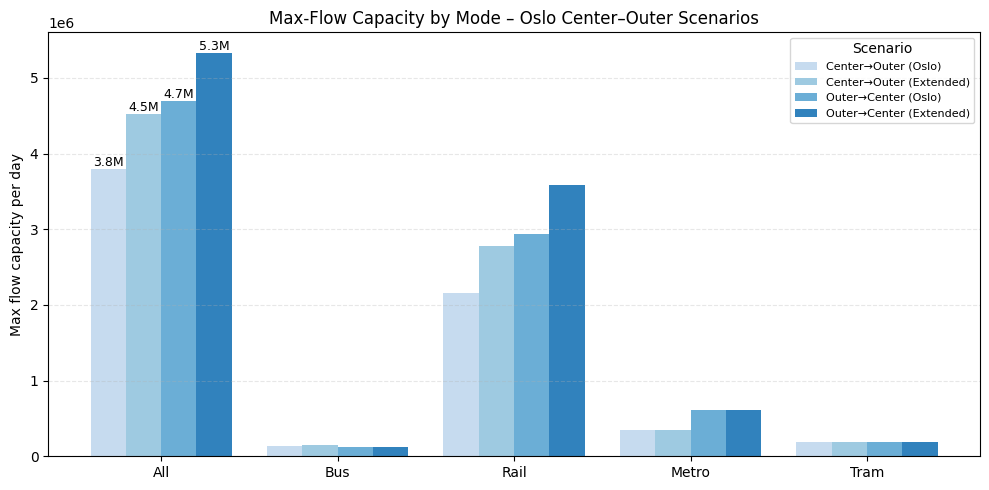

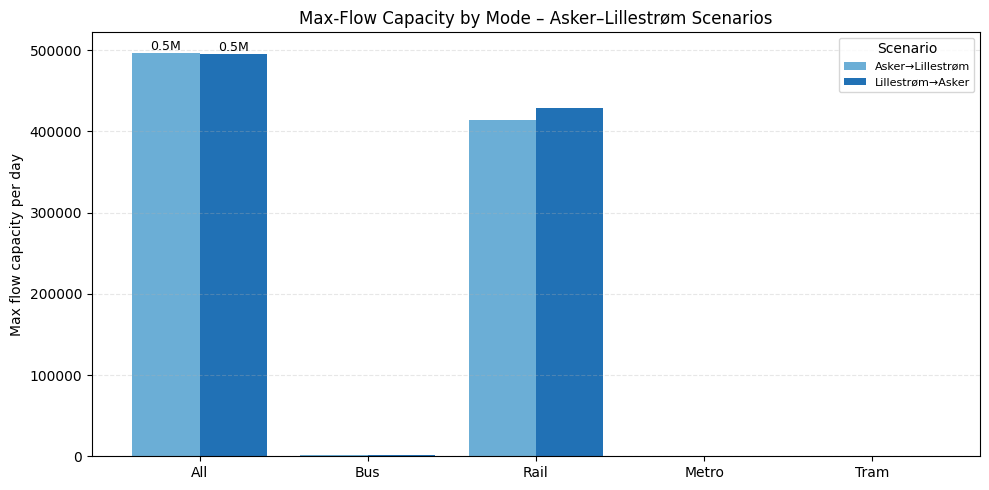

In [43]:
modes = ["All", "Bus", "Rail", "Metro", "Tram"]

scenarios = [
    "Center→Outer (Oslo)",
    "Center→Outer (Extended)",
    "Outer→Center (Oslo)",
    "Outer→Center (Extended)",
    "Asker→Lillestrøm",
    "Lillestrøm→Asker",
]

# Decided to bruteforce this, since at time of modelling, I stumbled over different var names etc. If time, I'll clean workbook to use vars instead of hardcoded values from printout results
flows = {
    "Center→Outer (Oslo)": [
        3_798_350,   # All
        140_650,     # Bus
        2_152_640,   # Rail
        341_600,     # Metro
        182_340,     # Tram
    ],
    "Center→Outer (Extended)": [
        4_517_960,   # All
        142_800,     # Bus
        2_774_800,   # Rail
        341_600,     # Metro
        182_340,     # Tram
    ],
    "Outer→Center (Oslo)": [
        4_696_680,   # All
        119_900,     # Bus
        2_935_520,   # Rail
        610_400,     # Metro
        184_140,     # Tram
    ],
    "Outer→Center (Extended)": [
        5_334_390,   # All
        122_050,     # Bus
        3_585_680,   # Rail
        610_400,     # Metro
        184_140,     # Tram
    ],
    "Asker→Lillestrøm": [
        497_270,   # All
        1_050,   # Bus
        413_840,   # Rail
        0,   # Metro
        0,   # Tram
    ],
    "Lillestrøm→Asker": [
        495_060,   # All
        1_750,   # Bus
        428_400,   # Rail
        0,   # Metro
        0,   # Tram
    ],
}

# Scenario groups
oslo_scenarios = [
    "Center→Outer (Oslo)",
    "Center→Outer (Extended)",
    "Outer→Center (Oslo)",
    "Outer→Center (Extended)",
]

corridor_scenarios = [
    "Asker→Lillestrøm",
    "Lillestrøm→Asker",
]

# Blue palettes
OSLO_COLORS = ["#c6dbef", "#9ecae1", "#6baed6", "#3182bd"]
CORRIDOR_COLORS = ["#6baed6", "#2171b5"]


def plot_grouped_barchart(scenario_list, colors, title):
    x = np.arange(len(modes))
    n_scen = len(scenario_list)
    width = 0.8 / n_scen

    fig, ax = plt.subplots(figsize=(10, 5))

    for i, (scenario, color) in enumerate(zip(scenario_list, colors)):
        vals = np.array(flows[scenario], dtype=float)
        offset = (i - (n_scen - 1) / 2) * width
        xs = x + offset

        bars = ax.bar(xs, vals, width, label=scenario, color=color)

        # Label only the "All" bars (first mode) in millions
        for bar, val, mode in zip(bars, vals, modes):
            if mode != "All":
                continue
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{val / 1e6:.1f}M",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    ax.set_xticks(x)
    ax.set_xticklabels(modes)
    ax.set_ylabel("Max flow capacity per day")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend(title="Scenario", fontsize=8)

    fig.tight_layout()
    plt.savefig("images/"+title, dpi=300, bbox_inches="tight")
    plt.show()


# 2. SEPARATE CHARTS
plot_grouped_barchart(
    oslo_scenarios,
    OSLO_COLORS,
    "Max-Flow Capacity by Mode – Oslo Center–Outer Scenarios",
)

plot_grouped_barchart(
    corridor_scenarios,
    CORRIDOR_COLORS,
    "Max-Flow Capacity by Mode – Asker–Lillestrøm Scenarios",
)


## 4.4 Robustness

In [222]:
def node_flow_scores(flow_dict, S, T):
    """
    Compute how much flow passes out of each internal node (excluding S and T).
    """
    scores = defaultdict(float)
    exclude = {S, T}

    for u, nbrs in flow_dict.items():
        if u in exclude:
            continue
        for v, f in nbrs.items():
            if f <= 0:
                continue
            scores[u] += f

    return scores


In [223]:
def simulate_node_removals(
    G_base,
    modes,
    origins,
    destinations,
    critical_nodes,
    capacity_attr="capacity",
    single_only=False,
    verbose=False,
):
    results = {
        "base_flow": None,
        "single": [],
        "cumulative": [],
    }

    base_flow, _, S_base, T_base, _ = run_max_flow(
        G_base,
        origins=origins,
        destinations=destinations,
        capacity_attr=capacity_attr,
    )
    results["base_flow"] = base_flow

    if verbose:
        print(f"Base max flow (no removals): {base_flow}")

    # 2) Single-node failures
    for node in critical_nodes:
        Gm, o_sub, d_sub = subgraph_modes(
            G_base,
            modes,
            origins,
            destinations,
        )
        if node in Gm:
            Gm.remove_node(node)
        else:
            # node might not exist in this subgraph; skip but print
            results["single"].append((node, None))
            if verbose:
                print(f"Node {node} not in subgraph, skipping single removal.")
            continue

        flow_val, _, _, _, _ = run_max_flow(
            Gm,
            origins=o_sub,
            destinations=d_sub,
            capacity_attr=capacity_attr,
        )
        results["single"].append((node, flow_val))
        if verbose:
            print(f"Single removal {node}: flow={flow_val} (Δ={flow_val - base_flow})")

    # 3) Cumulative failures
    if not single_only:
        removed = set()
        for node in critical_nodes:
            removed.add(node)

            Gm, o_sub, d_sub = subgraph_modes(
                G_base,
                modes,
                origins,
                destinations,
            )
            # Remove all nodes seen so far
            Gm.remove_nodes_from(removed & set(Gm.nodes()))

            flow_val, _, _, _, _ = run_max_flow(
                Gm,
                origins=o_sub,
                destinations=d_sub,
                capacity_attr=capacity_attr,
            )
            results["cumulative"].append((set(removed), flow_val))
            if verbose:
                print(
                    f"Cumulative removal {len(removed)} nodes "
                    f"({node} latest): flow={flow_val} (Δ={flow_val - base_flow})"
                )

    return results


In [224]:
def direct_attack_robust_sim(g, origins, destinations, title, modes):    
    # 1) Filter graph by modes and viable origins/destinations
    g_sub, origins_sub, destinations_sub = subgraph_modes(
        g,
        modes,
        origins,
        destinations,
    )
    
    # 2) Run base max-flow once and get node scores
    base_flow, flow_dict, S, T, _ = run_max_flow(
        g_sub,
        origins_sub,
        destinations_sub,
        capacity_attr="capacity",
    )
    
    print(f"\n=== {title} ===")
    #print(f"Base flow: {base_flow:.2f}")
    
    scores = node_flow_scores(flow_dict, S=S, T=T)
    
    # pick top-k critical nodes by outgoing flow
    k = 10
    critical_nodes = sorted(scores, key=scores.get, reverse=True)[:k]
    print("\nTop critical nodes (by outgoing flow):")
    for n in critical_nodes:
        print(n, scores[n])
    
    # 3) Run robustness simulation on these critical nodes
    robust_results = simulate_node_removals(
        G_base=g,                   # use the same base graph that came in
        modes=modes,
        origins=origins,
        destinations=destinations,
        critical_nodes=critical_nodes,
        capacity_attr="capacity",
        single_only=False,
        verbose=False,              # keep it quiet here
    )

    # Quick summary so you can see if it looks sane
    single = robust_results["single"]
    cumulative = robust_results["cumulative"]
    #print(f"\nRobustness summary for {title}:")
    #print(f"  Base flow: {robust_results['base_flow']:.2f}")
    #print(f"  Single removals simulated: {len(single)}")
    #print(f"  Cumulative removals simulated: {len(cumulative)}")

    return robust_results


In [225]:
import random

def random_attack_robust_sim(
    g,
    origins,
    destinations,
    title,
    modes,
    k=10,
    seed=None,
):
    # 1) Filter graph by modes and viable origins/destinations
    g_sub, origins_sub, destinations_sub = subgraph_modes(
        g,
        modes,
        origins,
        destinations,
    )

    # 2) Run base max-flow once to get flow_dict (for node set) + base flow
    base_flow, flow_dict, S, T, _ = run_max_flow(
        g_sub,
        origins_sub,
        destinations_sub,
        capacity_attr="capacity",
    )

    # Use same internal node set as direct_attack_robust_sim (nodes with outgoing flow)
    scores = node_flow_scores(flow_dict, S=S, T=T)
    candidate_nodes = list(scores.keys())

    if not candidate_nodes:
        print(f"[random_attack_robust_sim] No flow-carrying internal nodes for: {title}")
        return {
            "base_flow": base_flow,
            "single": [],
            "cumulative": [],
        }

    # 3) Pick k random nodes from candidates
    if seed is not None:
        rng = random.Random(seed)
    else:
        rng = random

    k_eff = min(k, len(candidate_nodes))
    random_nodes = rng.sample(candidate_nodes, k_eff)

    # 4) Run robustness simulation on these random nodes
    robust_results = simulate_node_removals(
        G_base=g,
        modes=modes,
        origins=origins,
        destinations=destinations,
        critical_nodes=random_nodes,
        capacity_attr="capacity",
        single_only=False,
        verbose=False,
    )
    # print(f"\n=== {title} (RANDOM) ===")
    # print(f"Base flow: {robust_results['base_flow']:.2f}")
    # print(f"Random nodes: {random_nodes}")

    return robust_results


In [226]:
def append_results_to_csv(
    filename,
    mode_label,
    experiment_label,
    graph_label,
    attack_type,     # "targeted" or "random"
    run_id,          # 0 for targeted, 0..N-1 for random runs
    results,
):
    base = results["base_flow"]

    rows = []

    # Single removals (not super important for the plots, but still nice to keep)
    for step, (node_removed, flow_after) in enumerate(results["single"], start=1):
        if flow_after is None:
            continue

        rows.append({
            "mode": mode_label,
            "experiment": experiment_label,
            "graph": graph_label,
            "attack_type": attack_type,
            "run_id": run_id,
            "removal_type": "single",
            "step": step,
            "removed_nodes": node_removed,
            "node_removed": node_removed,
            "flow": flow_after,
            "flow_ratio": flow_after / base if base > 0 else None,
        })

    # Cumulative removals (this is what you’ll actually plot)
    for step, (removed_set, flow_after) in enumerate(results["cumulative"], start=1):
        rows.append({
            "mode": mode_label,
            "experiment": experiment_label,
            "graph": graph_label,
            "attack_type": attack_type,
            "run_id": run_id,
            "removal_type": "cumulative",
            "step": step,
            "removed_nodes": list(removed_set),
            "node_removed": None,
            "flow": flow_after,
            "flow_ratio": flow_after / base if base > 0 else None,
        })

    if not rows:
        return

    write_header = not os.path.exists(filename)

    with open(filename, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=rows[0].keys())
        if write_header:
            writer.writeheader()
        writer.writerows(rows)


In [113]:
#WARNING! Did a benchmark and with randomnum 20 computing = around 20 minutes, so either just go look at the CSV already stored within RobustnessSim or run this block and go grab a coffee i guess
modes_to_test = {
    "all":   ["bus", "rail", "metro", "tram"], 
    "bus":   ["bus"],
    "rail":  ["rail"],
    "metro": ["metro"],
    "tram":  ["tram"],
}

# Experiment 1 O/D
origins_x_1, destinations_x_1 = central_outer_hubs(g_oslo)

# Experiment 2 O/D
origins_x_2 = destinations_x_1
destinations_x_2 = origins_x_1

# Experiment 3 O/D (Asker <-> Lillestrøm)
asker_lat = 59.832799
asker_lon = 10.433098
lillestrom_lat = 59.953348
lillestrom_lon = 11.044579
node_radius_m = 10
hub_names = ["Asker stasjon"]
sink_names =  ["Lillestrøm stasjon"]
origins_x_3 = []
destinations_x_3 = []
node_grouper(origins_x_3, hub_names, node_radius_m, asker_lat, asker_lon)
node_grouper(destinations_x_3, sink_names, node_radius_m, lillestrom_lat, lillestrom_lon)

CSV_OUT = "RobustnessSim/robustness_results.csv"

# nuke old CSV so runs are clean
if os.path.exists(CSV_OUT):
    os.remove(CSV_OUT)

NUM_RANDOM_RUNS = 20

print("Starting robustness batch...")
for mode_label, modes in modes_to_test.items():
    print("Starting Sim for", modes)
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    
        # ========== EXPERIMENT 1: Central Hub -> Outer Zone ==========
    
        # Targeted, Oslo only
        r = direct_attack_robust_sim(
            g_oslo, origins_x_1, destinations_x_1,
            f"Central Hub to Outer Zone (Oslo only) [{mode_label}]",
            modes
        )
        append_results_to_csv(CSV_OUT, mode_label, "exp1", "oslo_only", "targeted", 0, r)
    
        # Random, Oslo only (NUM_RANDOM_RUNS runs)
        for run_id in range(NUM_RANDOM_RUNS):
            r_rand = random_attack_robust_sim(
                g_oslo, origins_x_1, destinations_x_1,
                f"Central Hub to Outer Zone (Oslo only, RANDOM) [{mode_label}]",
                modes,
                k=10,
                seed=None,   # or seed=(1234 + run_id) if you want reproducible randomness
            )
            append_results_to_csv(CSV_OUT, mode_label, "exp1", "oslo_only", "random", run_id, r_rand)
    
        # Targeted, Extended
        r = direct_attack_robust_sim(
            g_oslo_extended, origins_x_1, destinations_x_1,
            f"Central Hub to Outer Zone (Extended) [{mode_label}]",
            modes
        )
        append_results_to_csv(CSV_OUT, mode_label, "exp1", "extended", "targeted", 0, r)
    
        # Random, Extended
        for run_id in range(NUM_RANDOM_RUNS):
            r_rand = random_attack_robust_sim(
                g_oslo_extended, origins_x_1, destinations_x_1,
                f"Central Hub to Outer Zone (Extended, RANDOM) [{mode_label}]",
                modes,
                k=10,
                seed=None,
            )
            append_results_to_csv(CSV_OUT, mode_label, "exp1", "extended", "random", run_id, r_rand)
    
        # ========== EXPERIMENT 2: Outer Zone -> Central Hub ==========
    
        # Targeted, Oslo only
        r = direct_attack_robust_sim(
            g_oslo, origins_x_2, destinations_x_2,
            f"Outer to Central (Oslo only) [{mode_label}]",
            modes
        )
        append_results_to_csv(CSV_OUT, mode_label, "exp2", "oslo_only", "targeted", 0, r)
    
        # Random, Oslo only
        for run_id in range(NUM_RANDOM_RUNS):
            r_rand = random_attack_robust_sim(
                g_oslo, origins_x_2, destinations_x_2,
                f"Outer to Central (Oslo only, RANDOM) [{mode_label}]",
                modes,
                k=10,
                seed=None,
            )
            append_results_to_csv(CSV_OUT, mode_label, "exp2", "oslo_only", "random", run_id, r_rand)
    
        # Targeted, Extended
        r = direct_attack_robust_sim(
            g_oslo_extended, origins_x_2, destinations_x_2,
            f"Outer to Central (Extended) [{mode_label}]",
            modes
        )
        append_results_to_csv(CSV_OUT, mode_label, "exp2", "extended", "targeted", 0, r)
    
        # Random, Extended
        for run_id in range(NUM_RANDOM_RUNS):
            r_rand = random_attack_robust_sim(
                g_oslo_extended, origins_x_2, destinations_x_2,
                f"Outer to Central (Extended, RANDOM) [{mode_label}]",
                modes,
                k=10,
                seed=None,
            )
            append_results_to_csv(CSV_OUT, mode_label, "exp2", "extended", "random", run_id, r_rand)
    
        # ========== EXPERIMENT 3: Asker <-> Lillestrøm (Extended only) ==========
    
        # Asker -> Lillestrøm
        r = direct_attack_robust_sim(
            g_oslo_extended, origins_x_3, destinations_x_3,
            f"Asker to Lillestrøm (Extended) [{mode_label}]",
            modes
        )
        append_results_to_csv(CSV_OUT, mode_label, "exp3_a2l", "extended", "targeted", 0, r)
    
        for run_id in range(NUM_RANDOM_RUNS):
            r_rand = random_attack_robust_sim(
                g_oslo_extended, origins_x_3, destinations_x_3,
                f"Asker to Lillestrøm (Extended, RANDOM) [{mode_label}]",
                modes,
                k=10,
                seed=None,
            )
            append_results_to_csv(CSV_OUT, mode_label, "exp3_a2l", "extended", "random", run_id, r_rand)
    
        # Lillestrøm -> Asker
        r = direct_attack_robust_sim(
            g_oslo_extended, destinations_x_3, origins_x_3,
            f"Lillestrøm to Asker (Extended) [{mode_label}]",
            modes
        )
        append_results_to_csv(CSV_OUT, mode_label, "exp3_l2a", "extended", "targeted", 0, r)
    
        for run_id in range(NUM_RANDOM_RUNS):
            r_rand = random_attack_robust_sim(
                g_oslo_extended, destinations_x_3, origins_x_3,
                f"Lillestrøm to Asker (Extended, RANDOM) [{mode_label}]",
                modes,
                k=10,
                seed=None,
            )
            append_results_to_csv(CSV_OUT, mode_label, "exp3_l2a", "extended", "random", run_id, r_rand)

print("Directed + Random Robustness Tests Done")


amount of hub nodes:  74
amount of dest nodes:  1867
Starting robustness batch...
Starting Sim for ['bus', 'rail', 'metro', 'tram']
Starting Sim for ['bus']
Starting Sim for ['rail']
Starting Sim for ['metro']
Starting Sim for ['tram']
Directed + Random Robustness Tests Done


## 4.5 Plotting Robustness

In [227]:
# Load CSV
df = pd.read_csv("RobustnessSim/robustness_results_clean.csv")

# Focus on mode="all" for the main robustness analysis
df_all = df[df["mode"] == "all"].copy()

# Scenarios = all experiments you care about
scenarios = [
    ("Center->Outer",          "exp1",     "oslo_only"),
    ("Outer->Center",          "exp2",     "oslo_only"),
    ("Center->Outer (Ext.)",   "exp1",     "extended"),
    ("Outer->Center (Ext.)",   "exp2",     "extended"),
    ("Asker->Lillestrøm",      "exp3_a2l", "extended"),
    ("Lillestrøm->Asker",      "exp3_l2a", "extended"),
]


In [231]:
# Load CSV
df = pd.read_csv("RobustnessSim/robustness_results_clean.csv")

# Main robustness analysis = mode "all"
df_all = df[df["mode"] == "all"].copy()

# Scenarios = all experiments you care about
scenarios = [
    ("Center->Outer",          "exp1",     "oslo_only"),
    ("Outer->Center",          "exp2",     "oslo_only"),
    ("Center->Outer (Ext.)",   "exp1",     "extended"),
    ("Outer->Center (Ext.)",   "exp2",     "extended"),
    ("Asker->Lillestrøm",      "exp3_a2l", "extended"),
    ("Lillestrøm->Asker",      "exp3_l2a", "extended"),
]

results_auc = []
results_auc_modes = []

for scenario_name, exp, graph in scenarios:
    # =========================
    # 1) SCENARIO-LEVEL (mode="all")
    # =========================
    sub_all = df_all[
        (df_all["experiment"] == exp) &
        (df_all["graph"] == graph) &
        (df_all["removal_type"] == "cumulative")
    ].copy()

    if sub_all.empty:
        print(f"[WARN] No data (mode='all') for {scenario_name}")
        continue

    targ = sub_all[(sub_all["attack_type"] == "targeted") & (sub_all["run_id"] == 0)]
    targ = targ.sort_values("step")

    rand = sub_all[sub_all["attack_type"] == "random"]
    if rand.empty:
        print(f"[WARN] No random data (mode='all') for {scenario_name}")
        continue

    rand_mean = (
        rand.groupby("step", as_index=False)["flow_ratio"]
            .mean()
            .sort_values("step")
    )

    x_t = targ["step"].to_numpy()
    y_t = targ["flow_ratio"].to_numpy()

    x_r = rand_mean["step"].to_numpy()
    y_r = rand_mean["flow_ratio"].to_numpy()

    auc_targ = np.trapezoid(y_t, x_t)
    auc_rand = np.trapezoid(y_r, x_r)

    max_step = x_t.max() if len(x_t) > 0 else 1
    auc_targ_norm = auc_targ / max_step if max_step > 0 else np.nan
    auc_rand_norm = auc_rand / max_step if max_step > 0 else np.nan

    results_auc.append({
        "scenario": scenario_name,
        "experiment": exp,
        "graph": graph,
        "auc_targeted_norm": auc_targ_norm,
        "auc_random_norm": auc_rand_norm,
    })

    # =========================
    # 2) MODE-LEVEL (all modes)
    # =========================
    sub_modes = df[
        (df["experiment"] == exp) &
        (df["graph"] == graph) &
        (df["removal_type"] == "cumulative")
    ].copy()

    if sub_modes.empty:
        print(f"[WARN] No mode-level data for {scenario_name}")
        continue

    for mode in sorted(sub_modes["mode"].unique()):
        sub_m = sub_modes[sub_modes["mode"] == mode]

        targ_m = sub_m[(sub_m["attack_type"] == "targeted") & (sub_m["run_id"] == 0)]
        targ_m = targ_m.sort_values("step")

        rand_m = sub_m[sub_m["attack_type"] == "random"]
        if targ_m.empty or rand_m.empty:
            print(f"[WARN] Missing targeted/random for {scenario_name}, mode={mode}")
            continue

        rand_mean_m = (
            rand_m.groupby("step", as_index=False)["flow_ratio"]
                .mean()
                .sort_values("step")
        )

        x_t_m = targ_m["step"].to_numpy()
        y_t_m = targ_m["flow_ratio"].to_numpy()

        x_r_m = rand_mean_m["step"].to_numpy()
        y_r_m = rand_mean_m["flow_ratio"].to_numpy()

        auc_targ_m = np.trapezoid(y_t_m, x_t_m)
        auc_rand_m = np.trapezoid(y_r_m, x_r_m)

        max_step_m = x_t_m.max() if len(x_t_m) > 0 else 1
        auc_targ_norm_m = auc_targ_m / max_step_m if max_step_m > 0 else np.nan
        auc_rand_norm_m = auc_rand_m / max_step_m if max_step_m > 0 else np.nan

        results_auc_modes.append({
            "scenario": scenario_name,
            "experiment": exp,
            "graph": graph,
            "mode": mode,
            "auc_targeted_norm": auc_targ_norm_m,
            "auc_random_norm": auc_rand_norm_m,
        })

# ====== BUILD TABLES ======
auc_df = pd.DataFrame(results_auc)
auc_df_modes = pd.DataFrame(results_auc_modes)

# Scenario-level (mode="all"), as before
auc_table = auc_df[[
    "scenario", "auc_targeted_norm", "auc_random_norm"
]].rename(columns={
    "auc_targeted_norm": "AUC_Targeted",
    "auc_random_norm": "AUC_Random",
})

# Scenario + mode
auc_table_modes = auc_df_modes[[
    "scenario", "mode", "auc_targeted_norm", "auc_random_norm"
]].rename(columns={
    "auc_targeted_norm": "AUC_Targeted",
    "auc_random_norm": "AUC_Random",
})

# ====== SAVE ======
auc_table.to_csv("RobustnessSim/robustness_auc_table.csv", index=False)
auc_table_modes.to_csv("RobustnessSim/robustness_auc_table_modes.csv", index=False)

print(auc_table)
#print(auc_table_modes.head())
#well this doesnt work :( so chose to just make it a table in the report f it dfi.export(auc_table, "RobustnessSim/auc_table_all_modes.png")

               scenario  AUC_Targeted  AUC_Random
0         Center->Outer      0.690921    0.803486
1         Outer->Center      0.898084    0.895183
2  Center->Outer (Ext.)      0.819301    0.898041
3  Outer->Center (Ext.)      0.888742    0.895289
4     Asker->Lillestrøm      0.248158    0.367462
5     Lillestrøm->Asker      0.250297    0.899962


In [12]:
def plot_exp_with_both_graphs(exp, title, outfile=None):
    sub_all = df_all[
        (df_all["experiment"] == exp) &
        (df_all["removal_type"] == "cumulative")
    ]

    plt.figure(figsize=(8,5))

    for graph, glabel in [("oslo_only", "Oslo only"),
                          ("extended",  "Extended")]:
        sub = sub_all[sub_all["graph"] == graph]

        # Targeted
        targ = sub[(sub["attack_type"] == "targeted") & (sub["run_id"] == 0)]
        targ = targ.sort_values("step")
        if not targ.empty:
            plt.plot(
                targ["step"],
                100 * targ["flow_ratio"],
                label=f"{glabel} – targeted",
                linestyle="-"
            )

        # Random mean
        rand = sub[sub["attack_type"] == "random"]
        if not rand.empty:
            rand_mean = (
                rand.groupby("step", as_index=False)["flow_ratio"]
                    .mean()
                    .sort_values("step")
            )
            plt.plot(
                rand_mean["step"],
                100 * rand_mean["flow_ratio"],
                label=f"{glabel} – random avg",
                linestyle="--"
            )

    plt.xlabel("Number of nodes removed")
    plt.ylabel("Remaining max-flow [%]")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    if outfile:
        plt.savefig(outfile, dpi=300)


In [201]:
top_nodes_rows = []

for scenario_name, exp, graph in scenarios:
    sub = df_all[
        (df_all["experiment"] == exp) &
        (df_all["graph"] == graph) &
        (df_all["attack_type"] == "targeted") &
        (df_all["removal_type"] == "single") &
        (df_all["run_id"] == 0)
    ].copy()

    if sub.empty:
        print(f"[WARN] No targeted singles for {scenario_name}")
        continue

    sub = sub.sort_values("step").head(10)  # top-10 removals

    for _, row in sub.iterrows():
        top_nodes_rows.append({
            "scenario": scenario_name,
            "experiment": exp,
            "graph": graph,
            "rank": int(row["step"]),
            "node_id": row["removed_nodes"],
            "flow_after_removal": row["flow"],
            "flow_ratio": row["flow_ratio"],
        })

top_nodes_df = pd.DataFrame(top_nodes_rows)
top_nodes_df.to_csv("RobustnessSim/top10_critical_nodes_all_scenarios.csv", index=False)



In [205]:
def plot_robustness_experiments(csv_path="RobustnessSim/robustness_results_clean.csv"):
    df = pd.read_csv(csv_path)

    exp_titles = {
        "exp1":      "Exp 1: Central Hub → Outer Zone",
        "exp2":      "Exp 2: Outer Zone → Central Hub",
        "exp3_a2l":  "Exp 3: Asker → Lillestrøm",
        "exp3_l2a":  "Exp 3: Lillestrøm → Asker",
    }

    # Human-readable scenario labels (for legend)
    scenario_labels = {
        ("exp1", "oslo_only"):    "Oslo only",
        ("exp1", "extended"):     "Extended",
        ("exp2", "oslo_only"):    "Oslo only",
        ("exp2", "extended"):     "Extended",
        ("exp3_a2l", "extended"): "Extended",
        ("exp3_l2a", "extended"): "Extended",
    }

    # Only cumulative, mode = all
    dfc = df[
        (df["mode"] == "all") &
        (df["removal_type"] == "cumulative")
    ].copy()

    # Random average over runs
    df_random_avg = (
        dfc[dfc["attack_type"] == "random"]
        .groupby(["experiment", "graph", "step"], as_index=False)["flow_ratio"]
        .mean()
    )
    df_random_avg["attack"] = "random_avg"

    # Targeted (single run)
    df_targeted = dfc[
        (dfc["attack_type"] == "targeted") &
        (dfc["run_id"] == 0)
    ][["experiment", "graph", "step", "flow_ratio"]].copy()
    df_targeted["attack"] = "targeted"

    # Combine into one plotting frame
    df_plot = pd.concat([df_random_avg, df_targeted], ignore_index=True)

    # --- STYLE MAPS ---

    # Color encodes: (graph, attack)
    # Oslo-only: blue; Extended: orange; random = lighter tone.
    color_map = {
        ("oslo_only", "targeted"):   "#1f77b4",  # dark blue
        ("oslo_only", "random_avg"): "#9ecae1",  # light blue
        ("extended",  "targeted"):   "#ff7f0e",  # dark orange
        ("extended",  "random_avg"): "#fdd0a2",  # light orange
    }

    # Line style: just reinforces the attack type
    linestyle_map = {
        "targeted":   "solid",
        "random_avg": "dashed",
    }

    # Tiny vertical jitter to keep overlapping curves readable
    jitter_map = {
        "targeted":   0.0,
        "random_avg": -0.3,
    }

    experiments = sorted(df_plot["experiment"].unique())

    for exp in experiments:
        plt.figure(figsize=(10, 6))

        sub_exp = df_plot[df_plot["experiment"] == exp]

        for (graph, attack), sub in sub_exp.groupby(["graph", "attack"]):
            sub = sub.sort_values("step")

            color = color_map[(graph, attack)]
            linestyle = linestyle_map[attack]
            jitter = jitter_map[attack]

            scenario_name = scenario_labels.get((exp, graph), graph)
            attack_label = "targeted" if attack == "targeted" else "random avg"
            label = f"{scenario_name} ({attack_label})"

            plt.plot(
                sub["step"],
                100 * sub["flow_ratio"] + jitter,
                linewidth=2.2,
                alpha=0.95,
                linestyle=linestyle,
                color=color,
                label=label,
            )

        plt.title(f"Robustness – {exp_titles[exp]} (mode = all)")
        plt.xlabel("Number of nodes removed")
        plt.ylabel("Remaining max-flow [%]")
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
        plt.tight_layout()

        outfile = f"RobustnessSim/report_robustness_{exp}_mode_all.png"
        plt.savefig(outfile, dpi=300)
        plt.show()


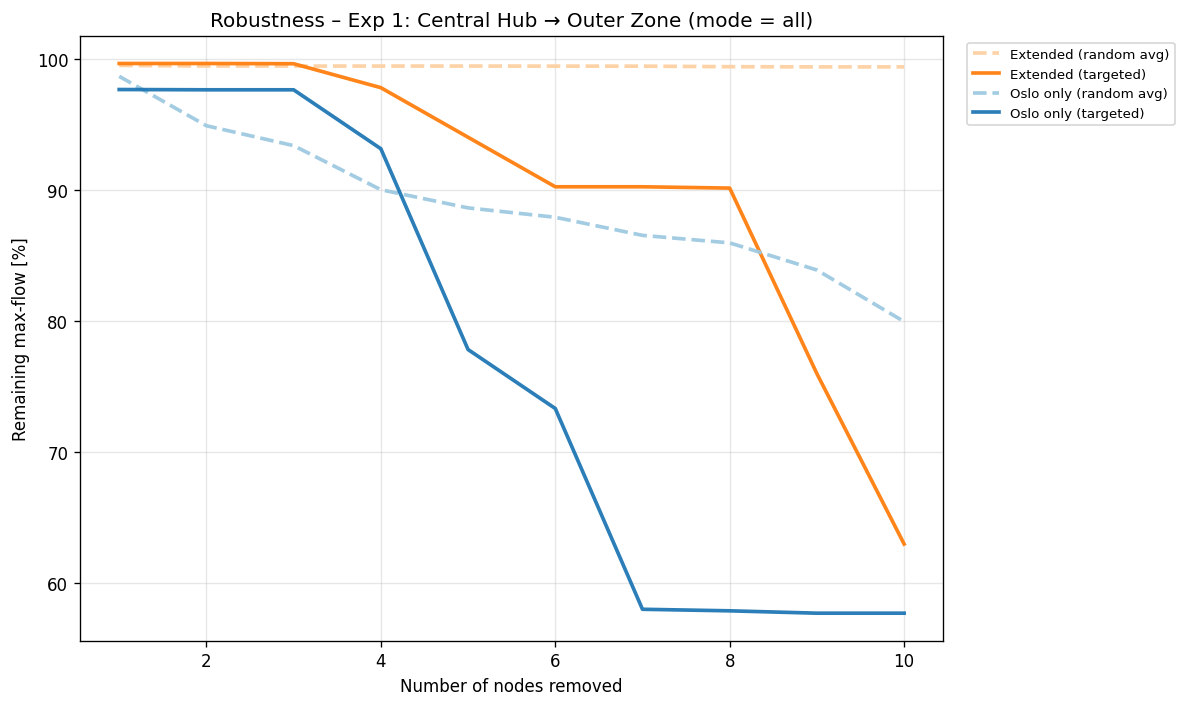

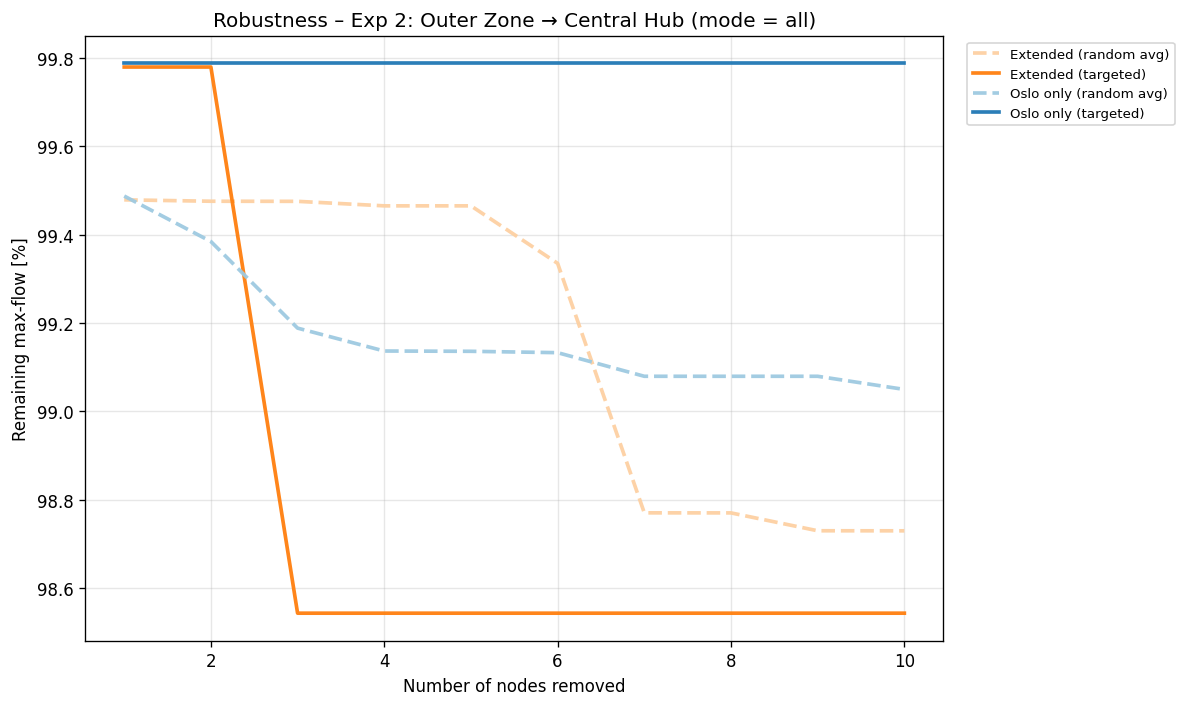

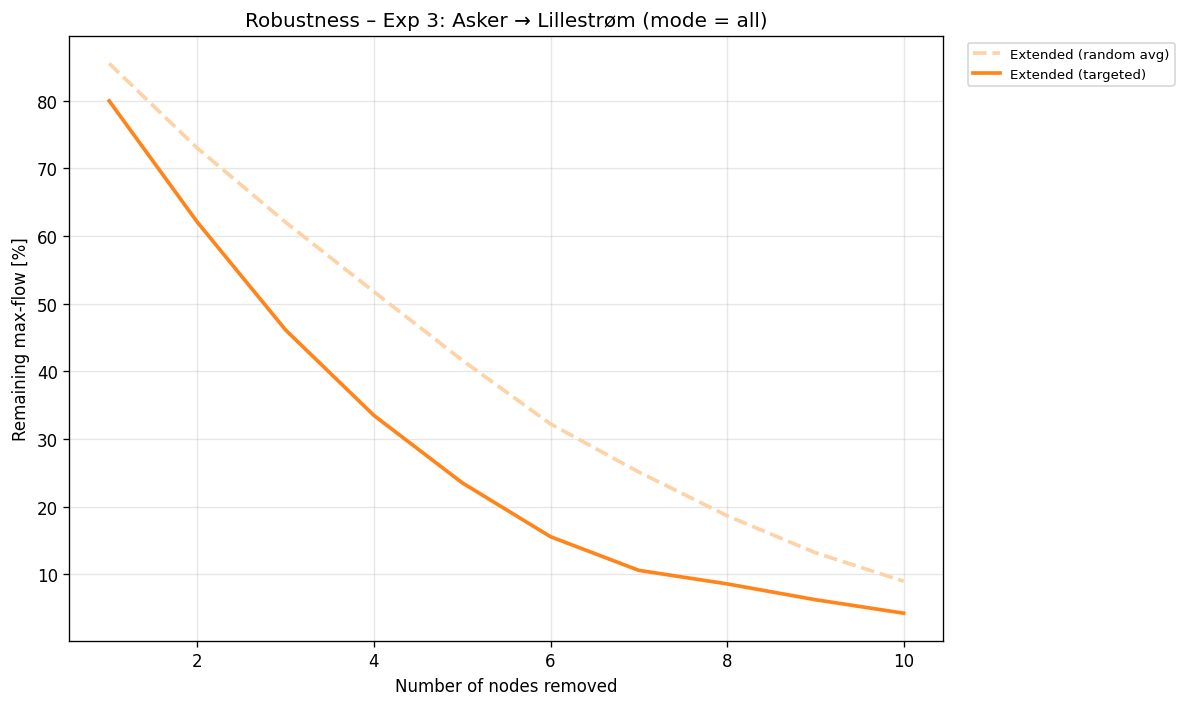

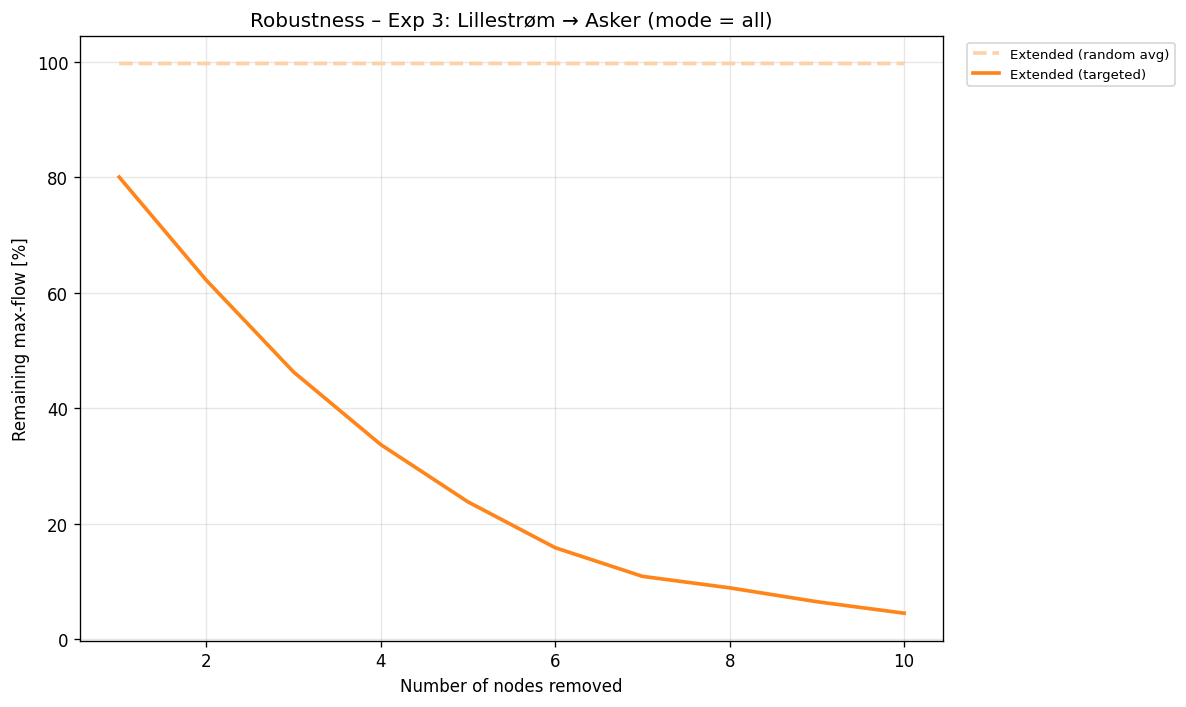

In [206]:
plot_robustness_experiments()

## 4.6 Unused experimental plotting

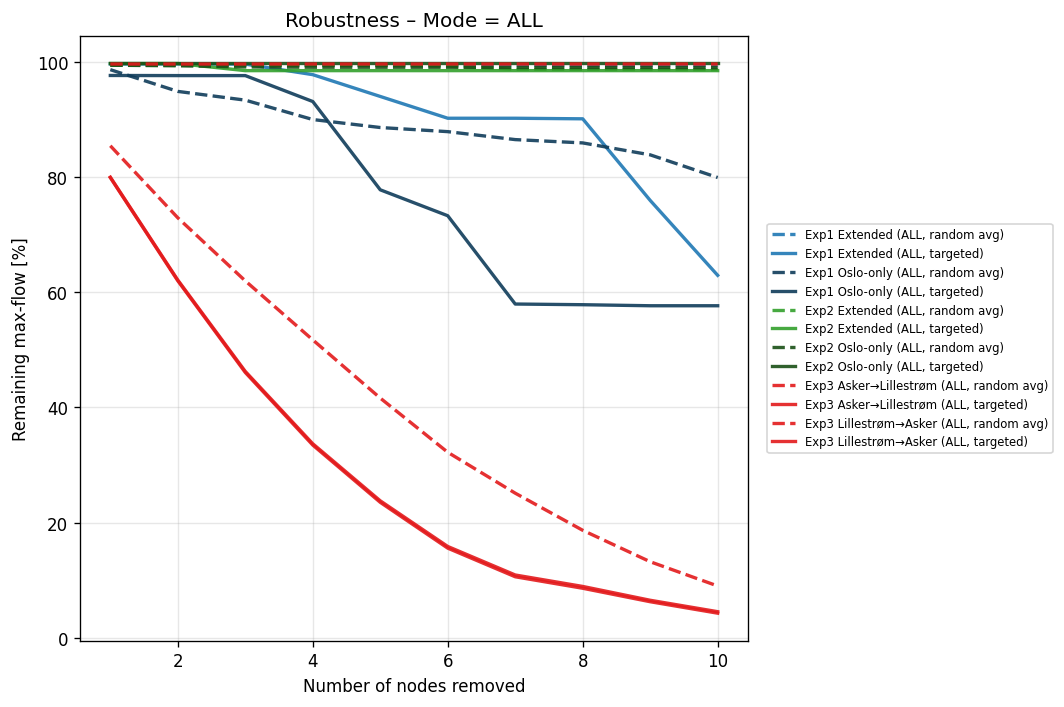

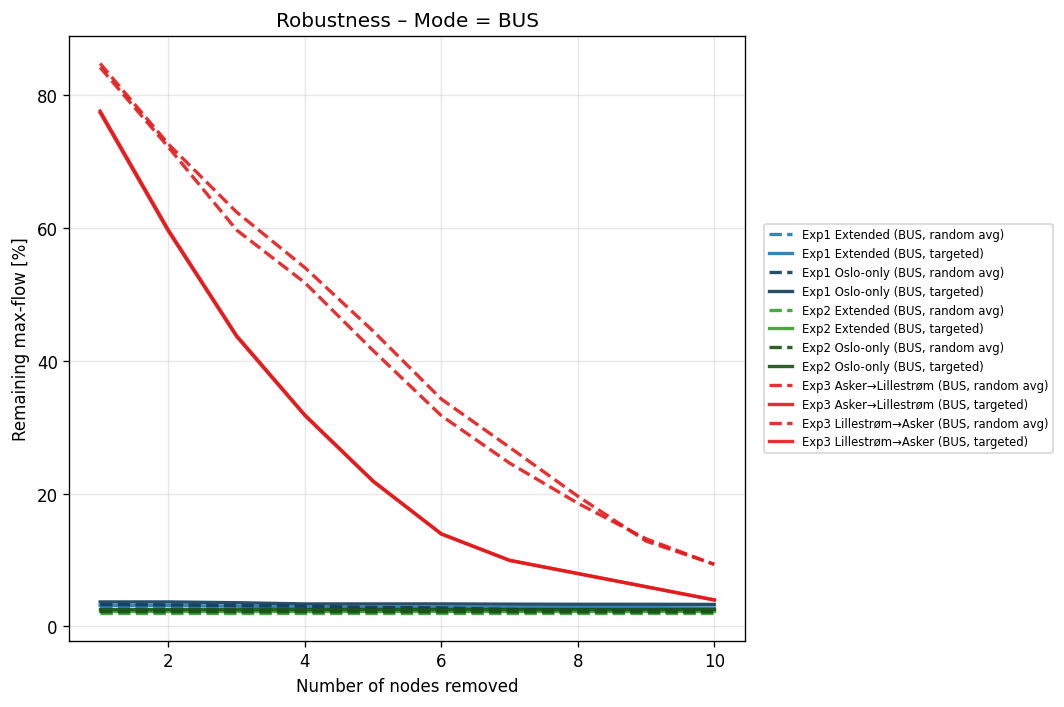

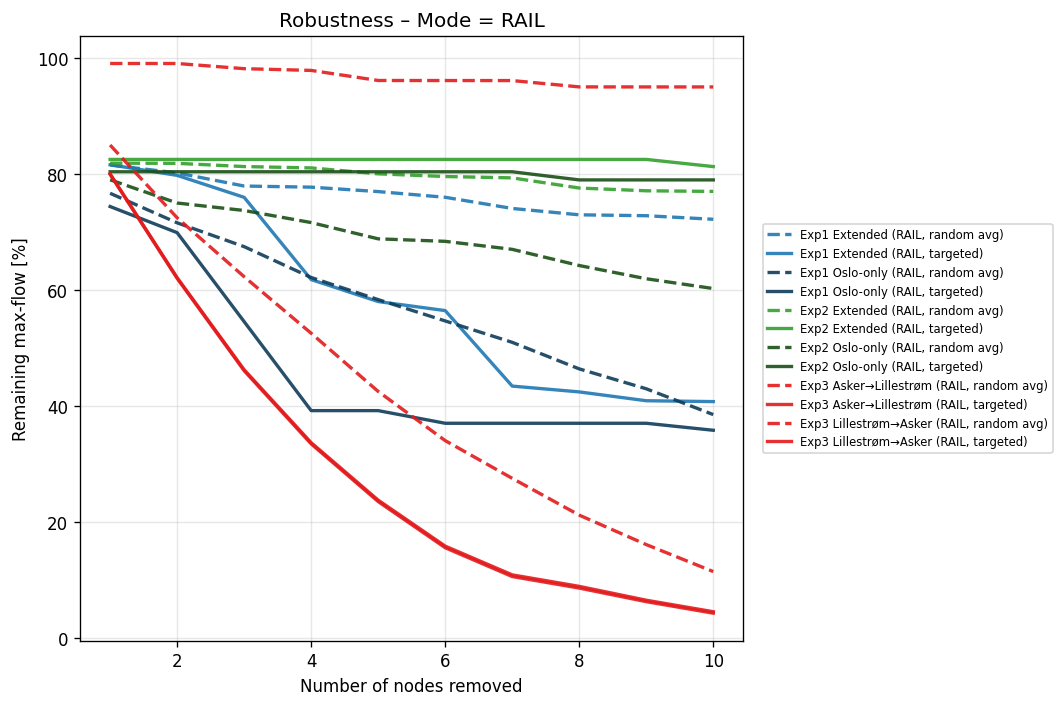

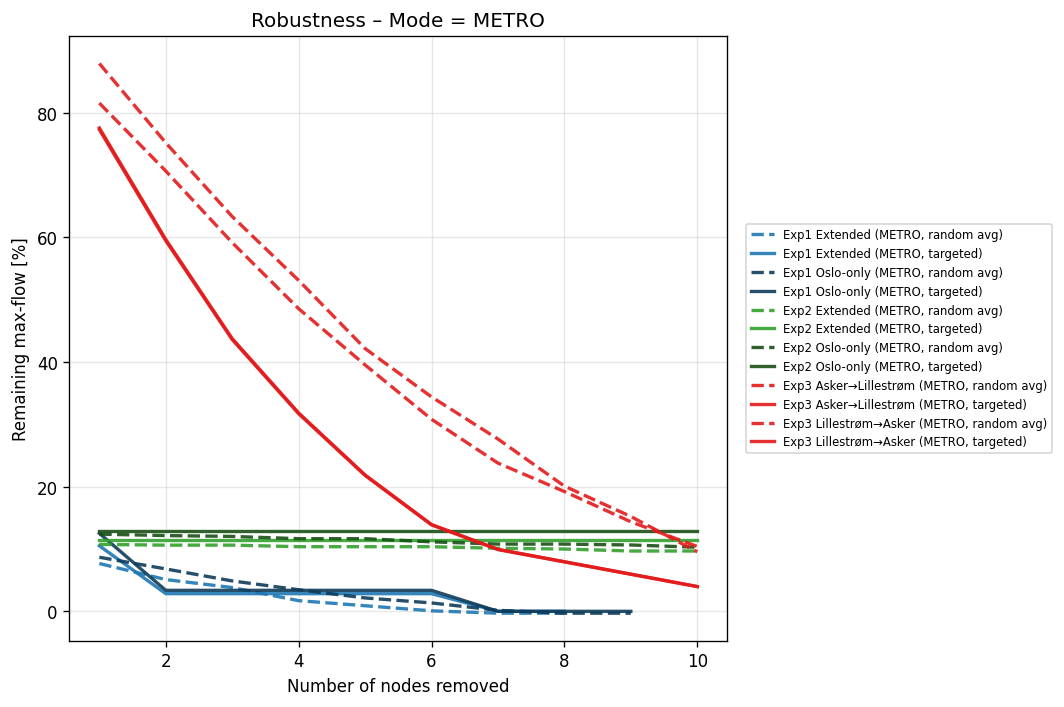

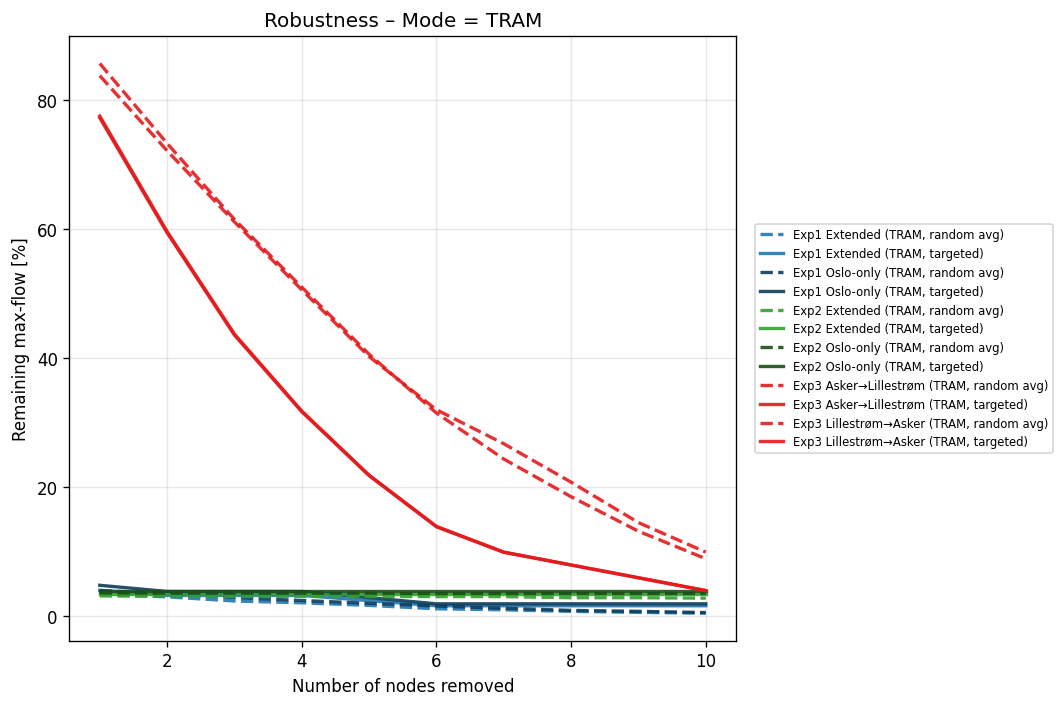

In [186]:
df = pd.read_csv("RobustnessSim/robustness_results_clean.csv")

# Filter cumulative removals only
dfc = df[df["removal_type"] == "cumulative"].copy()

# Random average
df_random_avg = (
    dfc[dfc["attack_type"] == "random"]
    .groupby(["mode", "experiment", "graph", "step"], as_index=False)["flow_ratio"]
    .mean()
)
df_random_avg["attack"] = "random_avg"

# Targeted (run_id=0)
df_targeted = dfc[
    (dfc["attack_type"] == "targeted") &
    (dfc["run_id"] == 0)
][["mode", "experiment", "graph", "step", "flow_ratio"]]
df_targeted["attack"] = "targeted"

df_plot = pd.concat([df_random_avg, df_targeted], ignore_index=True)

# Clean names
scenario_labels = {
    ("exp1", "oslo_only"):    "Exp1 Oslo-only",
    ("exp1", "extended"):     "Exp1 Extended",
    ("exp2", "oslo_only"):    "Exp2 Oslo-only",
    ("exp2", "extended"):     "Exp2 Extended",
    ("exp3_a2l", "extended"): "Exp3 Asker→Lillestrøm",
    ("exp3_l2a", "extended"): "Exp3 Lillestrøm→Asker",
}

# ------------------------------------------------------------
# Three *actual* experiment colors + light/dark variant
# ------------------------------------------------------------
exp_color = {
    "exp1": "#1f78b4",  # blue
    "exp2": "#33a02c",  # green
    "exp3": "#e31a1c",  # red
}

# brighter version for extended/oslo distinction
graph_variant = {
    "oslo_only": 0.50,   # dimmer
    "extended": 1.00,    # full color
}

def adjust_brightness(hex_color, factor):
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)
    return f"#{r:02x}{g:02x}{b:02x}"

linestyle_map = {"targeted": "solid", "random_avg": "dashed"}
jitter_map     = {"targeted": 0.0,    "random_avg": -0.3}

def scenario_name(exp, graph):
    return scenario_labels.get((exp, graph), f"{exp} {graph}")

def make_label(mode, exp, graph, attack):
    base = scenario_name(exp, graph)
    attack_label = "targeted" if attack == "targeted" else "random avg"
    return f"{base} ({mode.upper()}, {attack_label})"

# ----------------------------------------------------------
# One figure per mode, clean legend outside
# ----------------------------------------------------------

modes = ["all", "bus", "rail", "metro", "tram"]

for mode in modes:
    sub_mode = df_plot[df_plot["mode"] == mode]
    if sub_mode.empty:
        continue

    plt.figure(figsize=(9, 6))
    seen_labels = set()
    handles = []
    labels = []

    for (exp, graph, attack), sub in sub_mode.groupby(["experiment", "graph", "attack"]):
        sub = sub.sort_values("step")

        # Experiment determines color family
        base_color = exp_color[exp.replace("_a2l","").replace("_l2a","")] if exp.startswith("exp3") else exp_color[exp]
        # Graph determines brightness variant
        color = adjust_brightness(base_color, graph_variant[graph])

        linestyle = linestyle_map[attack]
        jitter = jitter_map[attack]
        label = make_label(mode, exp, graph, attack)

        is_new = label not in seen_labels
        legend_label = label if is_new else "_nolegend_"
        seen_labels.add(label)

        ln, = plt.plot(
            sub["step"],
            100 * sub["flow_ratio"] + jitter,
            linewidth=2.0,
            alpha=0.9,
            linestyle=linestyle,
            color=color,
            label=legend_label,
        )

        if legend_label != "_nolegend_":
            handles.append(ln)
            labels.append(label)

    plt.title(f"Robustness – Mode = {mode.upper()}")
    plt.xlabel("Number of nodes removed")
    plt.ylabel("Remaining max-flow [%]")
    plt.grid(True, alpha=0.3)

    # Legend OUTSIDE to the right
    plt.legend(handles, labels, fontsize=7, loc="center left", bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()


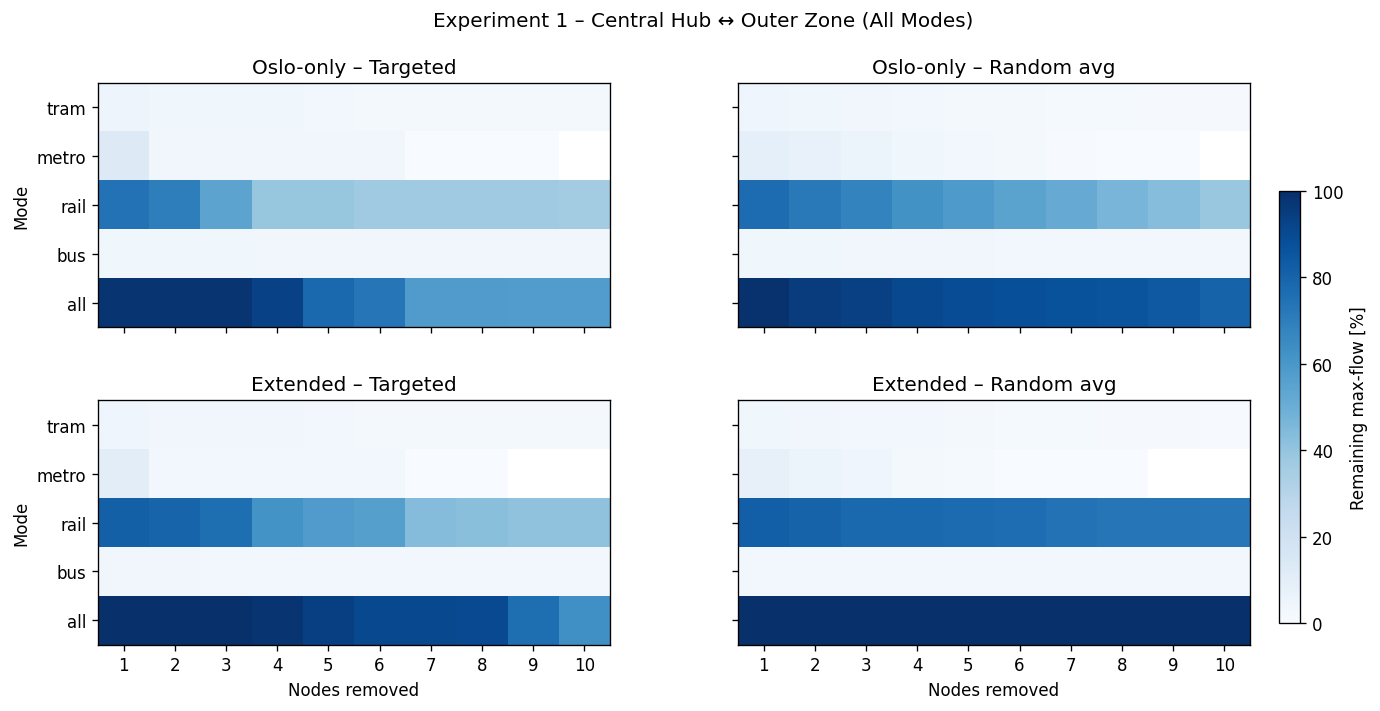

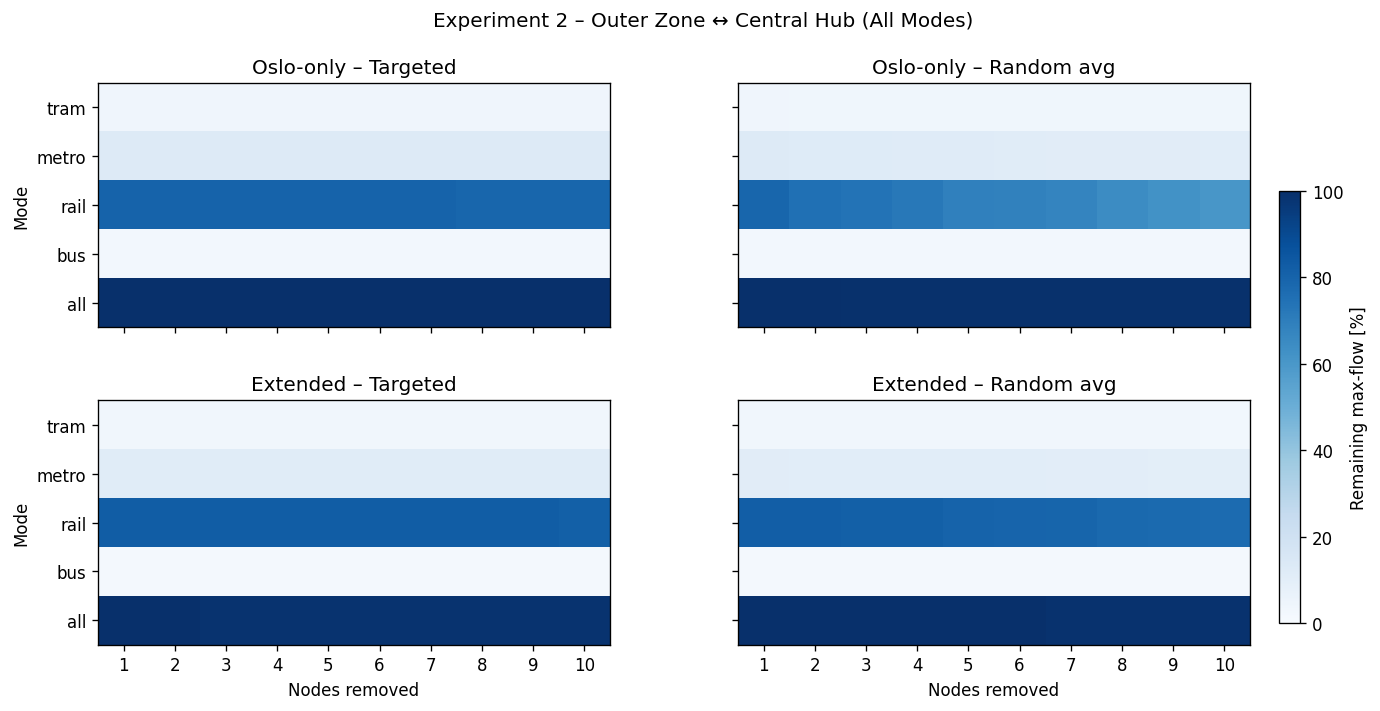

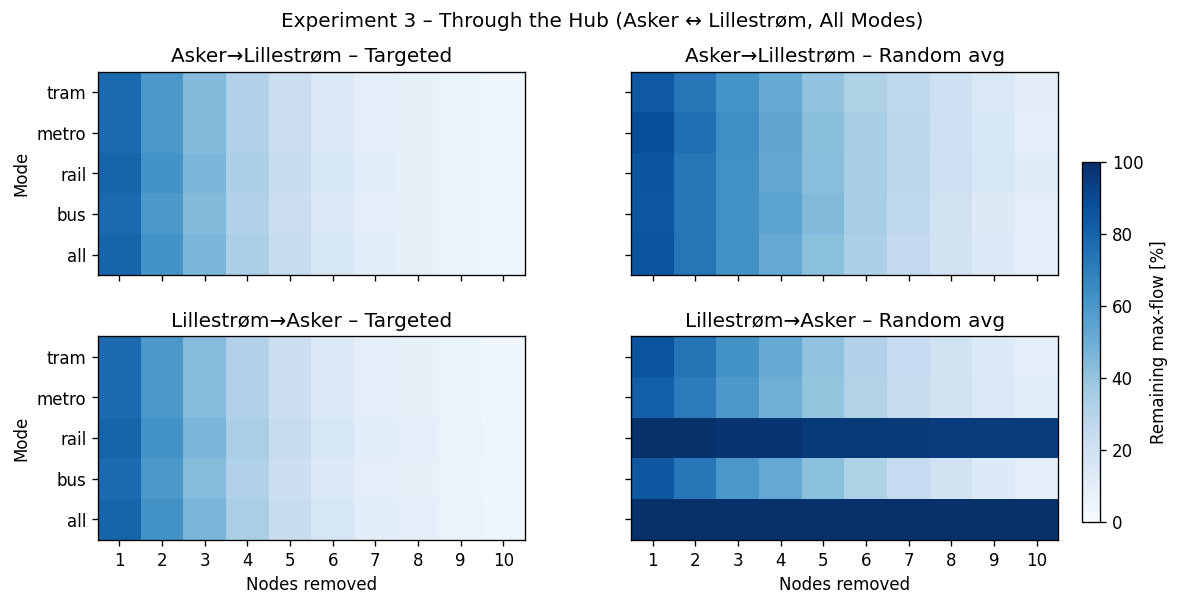

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("RobustnessSim/robustness_results_clean.csv")

# Only cumulative removals
dfc = df[df["removal_type"] == "cumulative"].copy()

# Helper: build matrix [modes x steps] for heatmap
def make_mode_step_matrix(sub):
    """
    sub: rows for one (experiment, graph, attack_type) combo
    returns:
        mat: 2D numpy array [len(modes) x len(steps)] with flow_ratio * 100
        modes, steps: ordered labels actually present
    """
    if sub.empty:
        return None, [], []

    if "run_id" in sub.columns:
        sub = sub.groupby(["mode", "step"], as_index=False)["flow_ratio"].mean()

    mode_order = ["all", "bus", "rail", "metro", "tram"]
    modes_present = [m for m in mode_order if m in sub["mode"].unique()]
    steps = sorted(sub["step"].unique())

    mat = np.full((len(modes_present), len(steps)), np.nan)
    for i, m in enumerate(modes_present):
        for j, s in enumerate(steps):
            val = sub[(sub["mode"] == m) & (sub["step"] == s)]["flow_ratio"]
            if not val.empty:
                mat[i, j] = float(val.iloc[0]) * 100.0  # percent

    return mat, modes_present, steps


def plot_experiment_heatmap_grid_exp1_exp2(exp, title):
    """
    For exp1 or exp2:
    rows: oslo_only / extended
    cols: targeted / random avg
    heatmap: modes x step (% flow)
    """
    sub_exp = dfc[dfc["experiment"] == exp].copy()

    fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
    graphs  = [("oslo_only", "Oslo-only"), ("extended", "Extended")]
    attacks = [("targeted", "Targeted"),   ("random", "Random avg")]

    im = None

    for i, (graph, glabel) in enumerate(graphs):
        for j, (attack_type, alabel) in enumerate(attacks):
            ax = axes[i, j]

            sub = sub_exp[
                (sub_exp["graph"] == graph) &
                (sub_exp["attack_type"] == attack_type)
            ].copy()

            if attack_type == "random":
                sub = (
                    sub.groupby(["mode", "step"], as_index=False)["flow_ratio"]
                       .mean()
                )

            mat, modes_present, steps = make_mode_step_matrix(sub)
            if mat is None:
                ax.set_visible(False)
                continue

            im = ax.imshow(
                mat,
                aspect="auto",
                origin="lower",
                cmap="Blues",
                vmin=0,
                vmax=100,
            )

            ax.set_title(f"{glabel} – {alabel}")
            ax.set_yticks(range(len(modes_present)))
            ax.set_yticklabels(modes_present)
            ax.set_xticks(range(len(steps)))
            ax.set_xticklabels(steps)

            if i == 1:
                ax.set_xlabel("Nodes removed")
            if j == 0:
                ax.set_ylabel("Mode")

    fig.suptitle(title, y=1)

    # Shrink subplot area to leave room for colorbar
    plt.subplots_adjust(
        left=0.08,
        right=0.88,   # <--- everything stays left of 0.88
        top=0.90,
        bottom=0.12,
        wspace=0.25,
        hspace=0.30,
    )

    # Dedicated colorbar axis OUTSIDE the grid
    if im is not None:
        cax = fig.add_axes([0.90, 0.15, 0.015, 0.6])  # [x0, y0, width, height]
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label("Remaining max-flow [%]")

    plt.show()


def plot_experiment_heatmap_grid_exp3(title):
    """
    For Exp3: 2x2 grid:
    rows: exp3_a2l / exp3_l2a (directions)
    cols: targeted / random avg
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)

    directions = [
        ("exp3_a2l", "Asker→Lillestrøm"),
        ("exp3_l2a", "Lillestrøm→Asker"),
    ]
    attacks = [("targeted", "Targeted"), ("random", "Random avg")]

    im = None

    for i, (exp, dlabel) in enumerate(directions):
        sub_exp = dfc[dfc["experiment"] == exp].copy()

        for j, (attack_type, alabel) in enumerate(attacks):
            ax = axes[i, j]

            sub = sub_exp[sub_exp["attack_type"] == attack_type].copy()
            if attack_type == "random":
                sub = (
                    sub.groupby(["mode", "step"], as_index=False)["flow_ratio"]
                       .mean()
                )

            mat, modes_present, steps = make_mode_step_matrix(sub)
            if mat is None:
                ax.set_visible(False)
                continue

            im = ax.imshow(
                mat,
                aspect="auto",
                origin="lower",
                cmap="Blues",
                vmin=0,
                vmax=100,
            )

            ax.set_title(f"{dlabel} – {alabel}")
            ax.set_yticks(range(len(modes_present)))
            ax.set_yticklabels(modes_present)
            ax.set_xticks(range(len(steps)))
            ax.set_xticklabels(steps)

            if i == 1:
                ax.set_xlabel("Nodes removed")
            if j == 0:
                ax.set_ylabel("Mode")

    fig.suptitle(title, y=1)

    plt.subplots_adjust(
        left=0.08,
        right=0.88,   # grid stops at 0.88
        top=0.90,
        bottom=0.12,
        wspace=0.25,
        hspace=0.30,
    )

    if im is not None:
        cax = fig.add_axes([0.90, 0.15, 0.015, 0.6])
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label("Remaining max-flow [%]")

    plt.show()


# ---- Call these to generate figures ----
plot_experiment_heatmap_grid_exp1_exp2(
    "exp1",
    "Experiment 1 – Central Hub ↔ Outer Zone (All Modes)"
)

plot_experiment_heatmap_grid_exp1_exp2(
    "exp2",
    "Experiment 2 – Outer Zone ↔ Central Hub (All Modes)"
)

plot_experiment_heatmap_grid_exp3(
    "Experiment 3 – Through the Hub (Asker ↔ Lillestrøm, All Modes)"
)


In [ ]:
def plot_center_outer_allmodes(title, outfile=None):
    sub_all = df[
        (df["experiment"] == "exp1") &
        (df["removal_type"] == "cumulative")
    ].copy()

    # --- Palette dictionaries ---
    oslo_colors = {
        "all":   "#08306b",
        "bus":   "#08519c",
        "rail":  "#2171b5",
        "metro": "#4292c6",
        "tram":  "#6baed6",
    }

    extended_colors = {
        "all":   "#7f2704",
        "bus":   "#a63603",
        "rail":  "#d94801",
        "metro": "#f16913",
        "tram":  "#fdae6b",
    }

    # Attack styles
    attack_styles = {
        "targeted": ("-", 1.0),   # solid, full opacity
        "random":   ("--", 0.65), # dashed, lighter
    }

    plt.figure(figsize=(10, 7))

    for graph in ["oslo_only", "extended"]:
        for mode in ["all", "bus", "rail", "metro", "tram"]:
            sub = sub_all[
                (sub_all["graph"] == graph) &
                (sub_all["mode"] == mode)
            ]

            if sub.empty:
                continue

            # Pick palette
            base_color = oslo_colors[mode] if graph == "oslo_only" else extended_colors[mode]

            # Targeted
            targ = sub[(sub["attack_type"] == "targeted") & (sub["run_id"] == 0)]
            if not targ.empty:
                ls, alpha = attack_styles["targeted"]
                label = f"{graph.replace('_',' ').title()}, {mode} – targeted"
                plt.plot(
                    targ["step"], 100 * targ["flow_ratio"],
                    linestyle=ls,
                    color=base_color,
                    alpha=alpha,
                    linewidth=2.0,
                    label=label
                )

            # Random
            rand = sub[sub["attack_type"] == "random"]
            if not rand.empty:
                rand_m = (
                    rand.groupby("step", as_index=False)["flow_ratio"]
                        .mean()
                        .sort_values("step")
                )
                ls, alpha = attack_styles["random"]
                label = f"{graph.replace('_',' ').title()}, {mode} – random avg"
                plt.plot(
                    rand_m["step"], 100 * rand_m["flow_ratio"],
                    linestyle=ls,
                    color=base_color,
                    alpha=alpha,
                    linewidth=2.0,
                    label=label
                )

    plt.xlabel("Number of nodes removed")
    plt.ylabel("Remaining max-flow [%]")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=7, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
    plt.show()


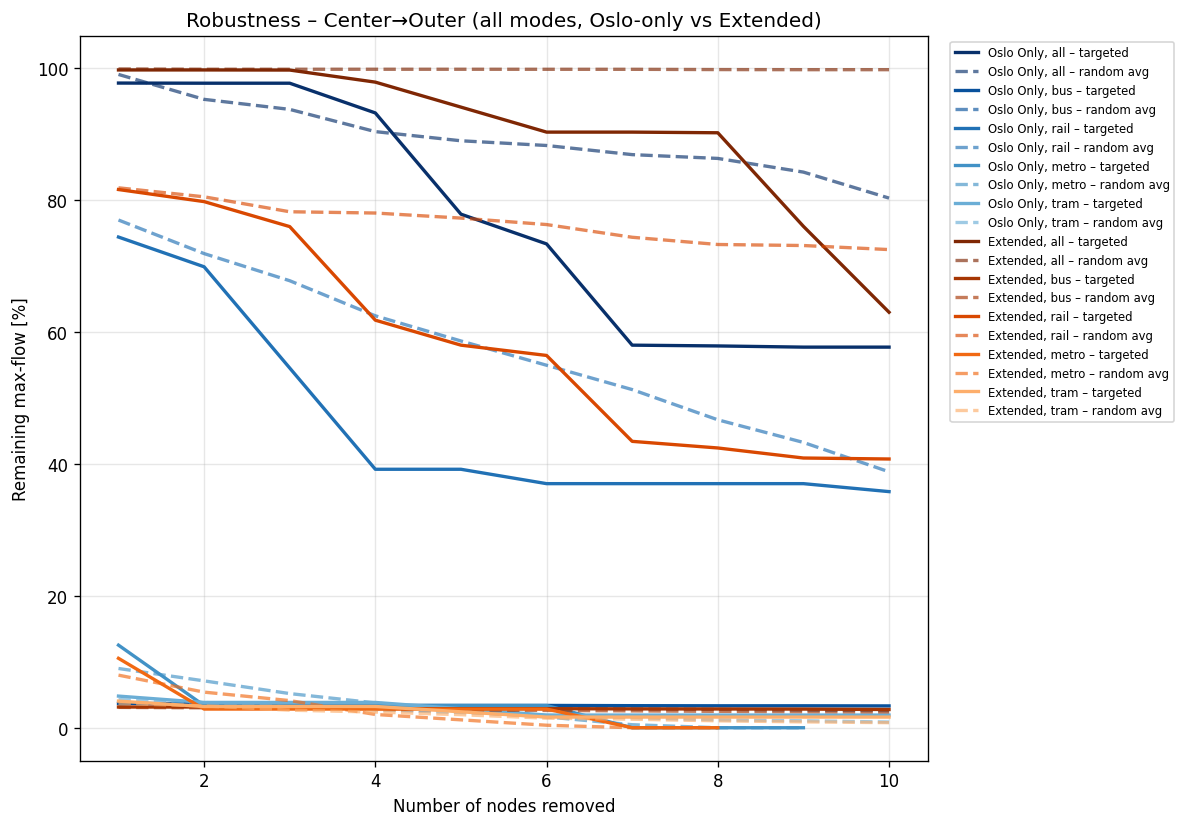

In [199]:
plot_center_outer_allmodes(
    title="Robustness – Center→Outer (all modes, Oslo-only vs Extended)",
    outfile="RobustnessSim/center_outer_mode_all.png"
)


## 4.7 AUC min-max

In [46]:
#Finding lowest and highest AUC from all modes
import pandas as pd

auc = pd.read_csv("RobustnessSim/robustness_auc_table_modes.csv")
summary = auc.groupby("mode")[["AUC_Targeted", "AUC_Random"]].agg(["min", "max"])

print(summary)


      AUC_Targeted           AUC_Random          
               min       max        min       max
mode                                             
all       0.248158  0.898084   0.367462  0.899962
bus       0.020546  0.235905   0.020546  0.376939
metro     0.024254  0.235724   0.021340  0.382629
rail      0.247955  0.741778   0.379291  0.872975
tram      0.021363  0.235724   0.017208  0.367958


# Debugging
This will be cleaned whenever functions are no longer necessary or redundancy is built into functions